# Continuous Time Hazards and Survival Analysis with Bambi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bambi as bmb 
import warnings
from scipy.stats import weibull_min
import arviz as az
import pymc as pm

import pytensor.tensor as pt
import pytensor

np.random.seed(42)
warnings.filterwarnings('ignore')

## From Discrete to Continuous Time

In this notebook we will explore survival modelling techniques in the continuous time formulation. This modelling strategy is often computationally quite efficient because it allows you to explicitly handle censored data without exploding the dataset size via person-period transformations. The data for some subjects is "censored" if there is no event or state-change recorded for those subjects. If we don't handle this aspect of the sample data correctly we risk skewing our conclusions.

Before we get to the applied sections, we need to establish some theoretical ground. We will:

- Recap discrete-time approaches
- Distinguish proportional hazards from accelerated failure time interpretations
- Outline the Weibull as the canonical parametric family for survival modelling
- Describe how parametric models handle censoring

Once this ground is established, we turn to practice. First with a simulation study that recovers known parameters, then with a people analytics example modelling time-to-attrition.

### Recap: The Discrete-Time Approach

In the companion notebook on discrete-time survival, we showed that survival analysis is fundamentally regression with a clever data structure. We discretized time into periods, created person-period data, and fitted binary regression models with a cloglog link. The cloglog link gave us coefficients interpretable as log hazard ratios — the same quantities as Cox proportional hazards.

That approach works well when:

- Time is naturally discrete (years, visits, exam sittings)
- You want maximum flexibility in the baseline hazard shape
- You're comfortable expanding data to person-period format. 
    - In the discrete case censoring is handled with this data transformation. Risk is assessed conditional on the observed person-period.

But sometimes continuous time is more natural. Clinical trial data records survival to the day or hour. Engineering failure data is measured in continuous operating time. In these settings, **parametric continuous-time models** offer a different set of trade-offs:

- **Fewer parameters**: A Weibull model describes the entire baseline hazard with just two numbers (shape and scale)
- **Interpolation and extrapolation**: Smooth hazard functions can predict at any time point, not just observed periods
- **Direct probabilistic interpretation**: The likelihood is defined on the continuous time axis, no discretization needed
- **Efficiency**: No person-period expansion — each subject contributes one row

The cost is that we must choose a parametric family for the baseline hazard. If we choose poorly, the model is misspecified. This notebook explores these trade-offs.

## Two Frameworks for Covariate Effects

Before fitting any models, we need to understand a conceptual fork in the road. There are two fundamentally different ways to think about how covariates affect survival. In the discrete time formulation we focused on the proportional hazards interpretation, however when shifting to continuous time distributional models the accelerated failure time view becomes available. 

::: {.callout-important}
## Proportional Hazards (PH) vs. Accelerated Failure Time (AFT)

**Proportional Hazards (PH)**: Covariates act multiplicatively on the *hazard function*. A treatment that halves the hazard does so at every time point. The hazard for subject $i$ is:

$$\lambda(t \mid X_i) = \lambda_0(t) \cdot \exp(X_i \beta)$$

Coefficients are **log hazard ratios**: $\exp(\beta_j)$ tells you the factor by which the hazard is multiplied for a one-unit increase in $X_j$. This was the interpretation of coefficients we discussed in the discrete time formulations of survival modelling.

**Accelerated Failure Time (AFT)**: Covariates act multiplicatively on the *time scale*. A treatment that doubles survival time "stretches" the time axis by a factor of 2. For the Weibull case, the model is:

$$T_i \sim \text{Weibull}(\alpha, \lambda_i), \qquad \log(\lambda_i) = \mu + X_i \gamma$$

where $\alpha$ is the shape parameter (shared across subjects, estimated from data) and $\lambda_i$ is the per-subject scale determined by covariates. Coefficients are **log time ratios**: $\exp(\gamma_j)$ tells you the factor by which survival time is multiplied for a one-unit increase in $X_j$.

**The key difference**:

- In PH, a positive coefficient *increases hazard* (bad for survival)
- In AFT, a positive coefficient *increases survival time* (good for survival)
- PH operates on the hazard (vertical axis); AFT operates on time (horizontal axis)
:::

These two frameworks sometimes coincide. For the Weibull distribution — and *only* for the Weibull among standard parametric families — the same model can be written in both PH and AFT form. The exponential is a special case of the Weibull, so it also has this dual representation. For other distributions (log-normal, log-logistic), only the AFT form applies.

Bambi's `family="weibull"` with `link="log"` fits the **AFT parameterization**. We'll see how to convert to PH interpretation later.

### We are still modelling risk accumulation

Survival analysis models events as the outcome of an underlying risk accumulation process evolving over time. At each moment, covariates influence the rate at which risk increases, bringing the system closer to a latent transition threshold. Continuous-time models represent the accumulation of risk directly through the hazard and cumulative hazard functions, although these are now derived directly from the PDF and CDF of the parametric distribution.

This is an extra layer of abstraction, and often prevents people from "getting" survival analysis. Not only do you need to understand the idea of latent hazards, but you must work through the seemingly opaque mathematical abstractions of density functions! This is a barrier to understanding, but the core idea is simple: a single parametric distribution gives you the density, survival function, and hazard simultaneously. Choose the distribution, and all three quantities follow.

To gain intuition about these mathematical abstractions it is useful to focus on the histogram of time-to-event distributions. The histogram is a concrete object of study that is naturally translated into an empirical cumulative density function (ECDF). This gives us the proportion of observed events that have occurred by time $t$. This is an approximation of the parametric CDF which (if appropriate to the data) can be translated into the hazard quantities we need for survival modelling. It's a conceptual hook, not an exact identity. The ECDF will be biased unless we are able to handle censoring in the observed data. We'll see how to adjust for this issue below using the properties of the continuous time distribution. 

## The Weibull Distribution: Shape and Scale

One benefit of parametric approaches to survival modelling is that we can sample and plot the distributional assumptions. Usually with no more than two parameters we can explore a range of time-to-event distributions, and then the questions becomes more applied. Which is the appropriate parametric phrasing of our problem? 

### Why the Weibull?

The Weibull distribution is the workhorse of parametric survival analysis because it is flexible enough to capture three qualitatively different hazard patterns with just two parameters. There are a number of different ways to parameterize the Weibull distribution. The key point is that there is a shape parameter than controls the accumulation of risk.

- **Shape $\alpha < 1$**: Decreasing hazard (early failures, then stabilization — think infant mortality or burn-in failures)
- **Shape $\alpha = 1$**: Constant hazard (the exponential distribution — memoryless process)
- **Shape $\alpha > 1$**: Increasing hazard (wear-out, aging, accumulated damage)

The probability density, survival, and hazard functions used in PyMC and Bambi:

$$f(t) = \frac{\alpha}{\sigma}\left(\frac{t}{\sigma}\right)^{\alpha - 1} \exp\left(-\left(\frac{t}{\sigma}\right)^{\alpha}\right)$$

$$S(t) = \exp\left(-\left(\frac{t}{\sigma}\right)^{\alpha}\right), \qquad \lambda(t) = \frac{\alpha}{\sigma}\left(\frac{t}{\sigma}\right)^{\alpha - 1}$$

where $\alpha$ is the shape parameter and $\sigma$ is the scale parameter. The scale sets "how long" things take; the shape determines "how the risk changes over time."

With these properties we plot a range of different types of risk accumulation phenomena.


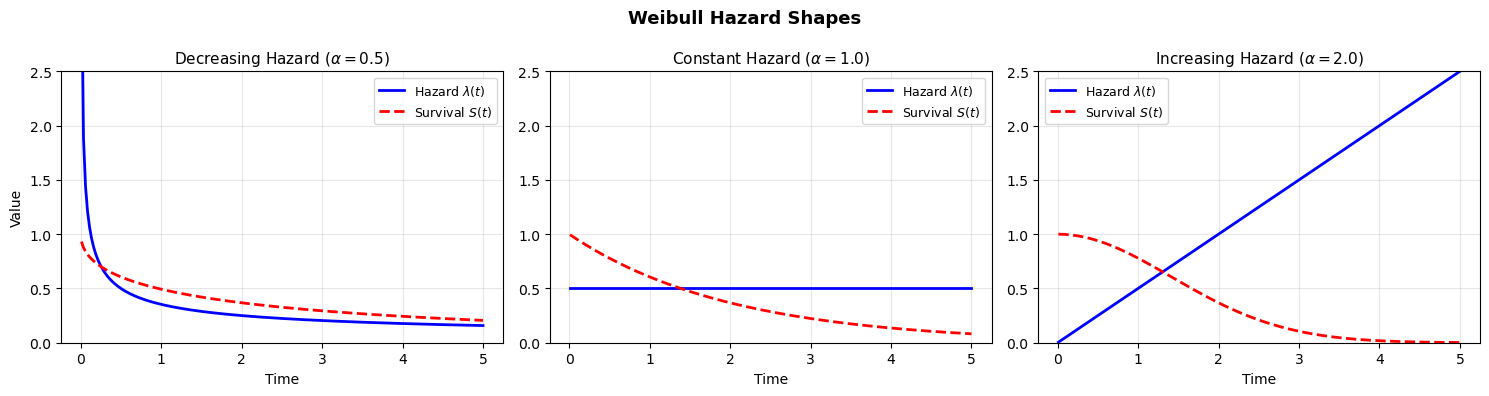

In [2]:
#| code-fold: true

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
t = np.linspace(0.01, 5, 200)
scale = 2.0

for alpha, ax, title in zip(
    [0.5, 1.0, 2.0], axes,
    [r'Decreasing Hazard ($\alpha=0.5$)',
     r'Constant Hazard ($\alpha=1.0$)',
     r'Increasing Hazard ($\alpha=2.0$)']
):
    # Hazard: (alpha/sigma) * (t/sigma)^(alpha-1)
    hazard = (alpha / scale) * (t / scale) ** (alpha - 1)
    survival = np.exp(-(t / scale) ** alpha)

    ax.plot(t, hazard, 'b-', linewidth=2, label='Hazard $\\lambda(t)$')
    ax.plot(t, survival, 'r--', linewidth=2, label='Survival $S(t)$')
    ax.set_xlabel('Time')
    ax.set_title(title, fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 2.5)

axes[0].set_ylabel('Value')
plt.suptitle('Weibull Hazard Shapes', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

The shape parameter is what makes the Weibull so useful: it lets the data tell us whether risk is increasing, decreasing, or constant over time. The exponential model forces $\alpha = 1$ — a strong and often unrealistic assumption. So we can move between different views of accumulating risk with these parametric families, but how do we handle censored data?

### How Parametric Models Handle Censoring

One major advantage of continuous-time parametric models is that censoring is handled *directly in the likelihood*, without expanding the dataset or imputing missing event times.

Suppose for each individual we observe:

- $t_i$ = observed time  
- $\delta_i$ = event indicator  
  - $\delta_i = 1$ if the event occurred  
  - $\delta_i = 0$ if the observation is right-censored  

In a parametric survival model, we specify a probability density function $f(t \mid \theta)$ and corresponding survival function $S(t \mid \theta)$.

#### Likelihood contribution

Each individual contributes:

- If the event is observed ($\delta_i = 1$):  
  $$
  f(t_i \mid \theta)
  $$

- If the observation is right-censored ($\delta_i = 0$):  
  $$
  S(t_i \mid \theta)
  $$

Why? Because censoring means:

> The event time exceeds $t_i$.

And by definition:

$$
P(T > t_i) = S(t_i)
$$

So the full likelihood is:

$$
L(\theta)
=
\prod_{i=1}^n
\left[
f(t_i \mid \theta)
\right]^{\delta_i}
\left[
S(t_i \mid \theta)
\right]^{1 - \delta_i}
$$

This is sometimes called the *censored likelihood* or *partial observation likelihood*.

### Intuition

- Events contribute density mass at the observed time.
- Censored observations contribute probability mass to the right of the observed time.
- No data expansion is required.
- No bias is introduced, provided the censoring is non-informative.

This is fundamentally different from the naive ECDF, which treats censored observations as if the event never occurred and therefore produces inconsistent estimates of the true distribution.

## Simulation: Understanding the AFT Parameterization

We're now equipped with all the pieces to understand survival modelling in continuous time settings. Let's make it more concrete by simulating data from an AFT process. 

### Generating Data from a Known AFT Model

To build intuition, we first simulate data from a Weibull AFT model with known parameters, then check that we can recover them. This validation step is essential before trusting any model on real data.

The AFT model says that each subject's survival time is drawn from a Weibull distribution whose *scale* depends on their covariates, while the *shape* is shared across all subjects:

$$T_i \sim \text{Weibull}(\alpha, \lambda_i), \qquad \log(\lambda_i) = \mu + X_i\beta$$

The model estimates two things: the shape $\alpha$ (which controls how hazard evolves over time — increasing, constant, or decreasing) and the covariate coefficients $\beta$ (which shift the per-subject scale). Positive $\beta$ values *increase* the scale, which *stretches* survival times — the subject lives longer.

::: {.callout-tip collapse="true"}
## The AFT error-term notation

The AFT literature often writes the same model as $\log(T_i) = \mu + X_i\beta + \sigma \epsilon_i$, where $\epsilon_i$ follows a standard extreme value distribution and $\sigma = 1/\alpha$. This is mathematically equivalent — taking the log of a Weibull random variable produces an extreme value variate, and the Weibull shape $\alpha$ determines how dispersed these log-times are. We prefer the distributional form above because it maps directly to the code and avoids the potentially confusing $\sigma \epsilon_i$ product notation.
:::

In the simulation code below, this mapping is concrete:

- `log_scale = intercept_true + beta_treatment * treatment[i] + beta_age * age[i]` computes $\log(\lambda_i) = \mu + X_i\beta$
- `scale_i = np.exp(log_scale)` exponentiates to get the per-subject Weibull scale $\lambda_i$
- `weibull_min.rvs(c=shape_true, scale=scale_i)` draws $T_i \sim \text{Weibull}(\alpha, \lambda_i)$

The shape `shape_true` ($\alpha = 2$) is the same for every subject — it's a global parameter. Only the scale varies with covariates.

::: {.callout-note collapse="true"}
## Can $\alpha$ depend on covariates too?

In principle, yes — you could let the shape vary across subjects, so that different groups have qualitatively different hazard trajectories (e.g., increasing hazard for one group, decreasing for another). This falls under the umbrella of **distributional regression** (sometimes called GAMLSS), where every parameter of the response distribution can have its own linear predictor.

In practice, the standard AFT and PH models keep $\alpha$ shared. This is partly convention, partly pragmatism: estimating covariate effects on the shape requires considerably more data, and interpretation becomes harder — you're no longer just shifting survival times, but changing the *character* of the hazard over time. For this notebook we stick with the standard shared-$\alpha$ formulation, but it's worth knowing the extension exists when you have strong reason to believe hazard shapes differ across groups.
:::


In [3]:
np.random.seed(42)

# Sample size and covariates
n = 1000
treatment = np.random.binomial(1, 0.5, n)
age = np.random.normal(0, 1, n)

# True AFT parameters
shape_true = 2.0       # Weibull shape (hazard increases over time)
beta_treatment = 0.6   # Positive = LONGER survival in AFT
beta_age = -0.4        # Negative = SHORTER survival
intercept_true = 3.0   # Log-scale intercept

# Generate survival times from Weibull AFT
times = []
events = []
max_followup = 50

for i in range(n):
    # AFT: covariates shift the log-scale
    log_scale = intercept_true + beta_treatment * treatment[i] + beta_age * age[i]
    scale_i = np.exp(log_scale)

    # Draw from Weibull(shape, scale_i)
    time_i = weibull_min.rvs(c=shape_true, scale=scale_i)

    # Administrative censoring at max_followup
    if time_i <= max_followup:
        times.append(time_i)
        events.append(1)
    else:
        times.append(max_followup)
        events.append(0)

df = pd.DataFrame({
    'time': times,
    'event': events,
    'treatment': treatment,
    'age': age
})

print("SIMULATION PARAMETERS")
print("=" * 60)
print(f"True AFT coefficients:")
print(f"  Intercept (log-scale) = {intercept_true}")
print(f"  beta_treatment = {beta_treatment} (positive = longer survival)")
print(f"  beta_age = {beta_age} (negative = shorter survival)")
print(f"  shape (alpha) = {shape_true}")
print(f"\nEvents: {df['event'].sum()} ({100*df['event'].mean():.1f}%)")
print(f"Censored: {(1 - df['event']).sum():.0f} ({100*(1-df['event'].mean()):.1f}%)")

SIMULATION PARAMETERS
True AFT coefficients:
  Intercept (log-scale) = 3.0
  beta_treatment = 0.6 (positive = longer survival)
  beta_age = -0.4 (negative = shorter survival)
  shape (alpha) = 2.0

Events: 889 (88.9%)
Censored: 111 (11.1%)


### Visualizing the AFT Effect

The hallmark of an AFT model is that covariates shift survival times *horizontally* — they stretch or compress the time axis. Compare this to a proportional hazards model, where covariates shift the survival curve *vertically* (by scaling the hazard).


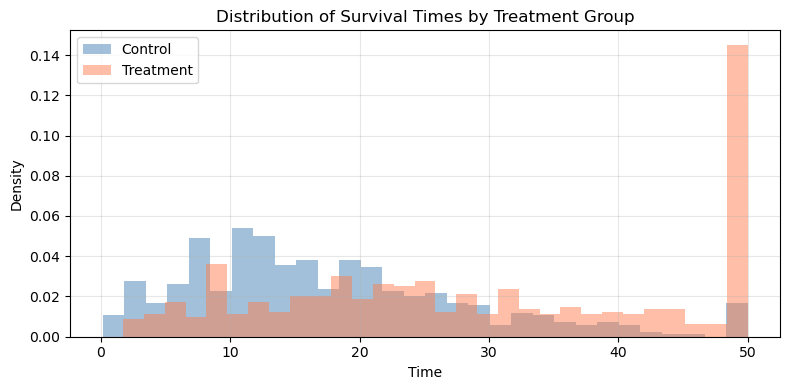

The treated group's distribution is shifted RIGHT along the time axis.
The AFT acceleration factor is exp(0.6) = 1.82x.
This means treatment multiplies expected survival time by ~1.82.


In [4]:
#| code-fold: true
#| fig-cap: "Treatment shifts the survival time distribution to the right — the AFT effect 'stretches' the time axis."

fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(df.loc[df['treatment'] == 0, 'time'], bins=30, alpha=0.5,
        density=True, label='Control', color='steelblue')
ax.hist(df.loc[df['treatment'] == 1, 'time'], bins=30, alpha=0.5,
        density=True, label='Treatment', color='coral')
ax.set_xlabel('Time')
ax.set_ylabel('Density')
ax.set_title('Distribution of Survival Times by Treatment Group')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The treated group's distribution is shifted RIGHT along the time axis.")
print(f"The AFT acceleration factor is exp({beta_treatment}) = {np.exp(beta_treatment):.2f}x.")
print("This means treatment multiplies expected survival time by ~1.82.")

Notice how the treatment group's distribution is shifted *rightward* (longer times), not just compressed downward. This horizontal shift is the signature of an AFT effect. In a PH model, the curves would have the same shape but one would be uniformly "pulled down" toward zero.

## Fitting Parametric Models with Bambi

### Handling Censoring in Bambi

Right-censoring occurs when we observe a subject for some period but the event hasn't happened by the end of observation. The subject contributes partial information: we know they survived *at least* until the censoring time, but not how much longer they would have survived.

In Bambi, we handle this with the `censored()` function in the formula. We create a column indicating the censoring status:

- `'none'` — the event was observed (uncensored)
- `'right'` — the subject was right-censored (still alive at last observation)

The censored likelihood correctly accounts for this: uncensored observations contribute the density $f(t)$ to the likelihood, while right-censored observations contribute $S(t)$ — the probability of surviving past the observed time.


In [5]:
# Create censoring indicator for Bambi
df['censoring'] = np.where(df['event'] == 1, 'none', 'right')

print("Censoring distribution:")
print(df['censoring'].value_counts())

Censoring distribution:
censoring
none     889
right    111
Name: count, dtype: int64


### Weibull AFT Model

We now can specify the Weibull AFT model using a convenient formula syntax and the appropriate link function. 

In [6]:
#| output: false
# Fit Weibull AFT model
model_aft = bmb.Model(
    "censored(time, censoring) ~ treatment + age",
    data=df,
    family="weibull",
    link="log"
)

print("MODEL STRUCTURE:")
print(model_aft)

MODEL STRUCTURE:
       Formula: censored(time, censoring) ~ treatment + age
        Family: weibull
          Link: mu = log
  Observations: 1000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.5338)
            treatment ~ Normal(mu: 0.0, sigma: 5.0001)
            age ~ Normal(mu: 0.0, sigma: 2.5292)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)


Estimating the model with the standard fit call. 

In [7]:
#| output: false
idata_aft = model_aft.fit(
    draws=1000,
    tune=1000,
    chains=4,
    random_seed=42,
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True}
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, treatment, age]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [8]:
print("WEIBULL AFT MODEL — POSTERIOR SUMMARY")
print("=" * 60)
summary_aft = az.summary(idata_aft, var_names=['Intercept', 'treatment', 'age', 'alpha'], hdi_prob=0.95)
print(summary_aft)

print(f"\nTrue values for comparison:")
print(f"  Intercept = {intercept_true}")
print(f"  treatment = {beta_treatment}")
print(f"  age       = {beta_age}")
print(f"  alpha     = {shape_true}")

WEIBULL AFT MODEL — POSTERIOR SUMMARY
            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  2.850  0.023     2.804      2.894      0.000    0.000    4580.0   
treatment  0.631  0.035     0.566      0.700      0.001    0.001    4753.0   
age       -0.390  0.019    -0.427     -0.354      0.000    0.000    5155.0   
alpha      1.952  0.054     1.853      2.062      0.001    0.001    4005.0   

           ess_tail  r_hat  
Intercept    3067.0    1.0  
treatment    3155.0    1.0  
age          2921.0    1.0  
alpha        2705.0    1.0  

True values for comparison:
  Intercept = 3.0
  treatment = 0.6
  age       = -0.4
  alpha     = 2.0


Which nicely recovers the true data generating parameters.

::: {.callout-note}
## Interpreting AFT Coefficients

The coefficients from a Weibull AFT model with `link="log"` are **log time-acceleration factors**:

- `treatment = 0.6` means treatment multiplies survival time by $\exp(0.6) \approx 1.82$. Treated subjects live about 82% longer in expectation.
- `age = -0.4` means a one-SD increase in age multiplies survival time by $\exp(-0.4) \approx 0.67$. This is a truncation effect. Older subjects have about 33% shorter survival times.

The sign convention is the *opposite* of proportional hazards: positive AFT coefficients are *protective* (longer survival), while positive PH coefficients are *harmful* (higher hazard).
:::

### Diagnostics

Before interpreting results, we should check that the sampler converged and mixed well.


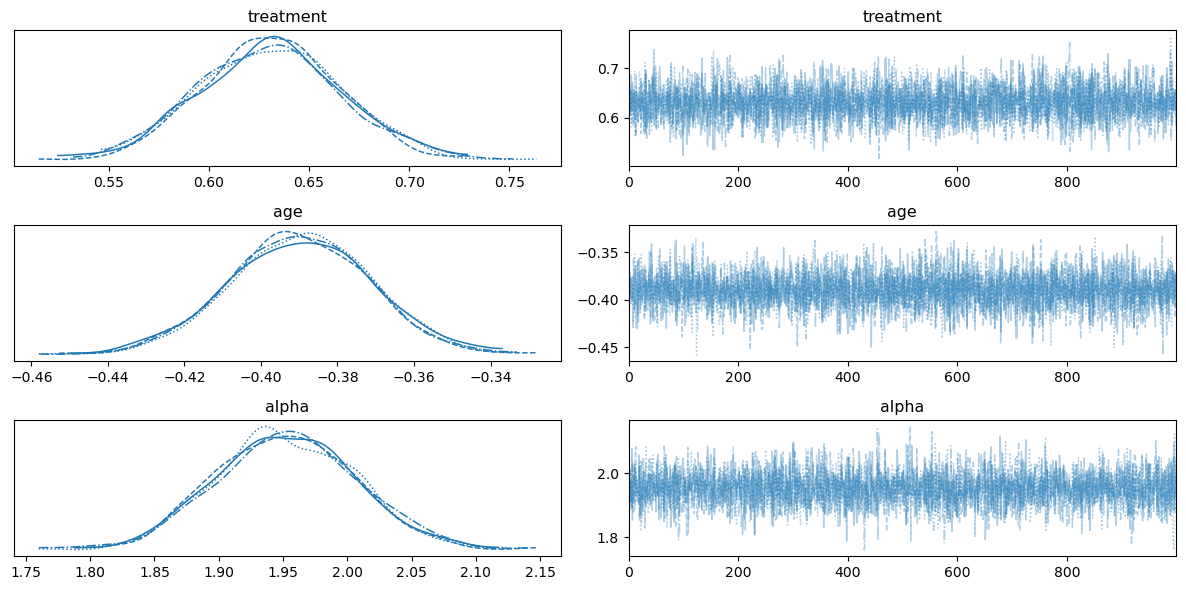

In [9]:
#| fig-cap: "Trace plots for the Weibull AFT model. Look for 'fuzzy caterpillars' in the trace (right) and overlapping densities across chains (left)."
az.plot_trace(idata_aft, var_names=['treatment', 'age', 'alpha'], compact=True)
plt.tight_layout()
plt.show()

In [10]:
# Check for divergences
divergences = idata_aft.sample_stats['diverging'].sum().values
print(f"Number of divergent transitions: {divergences}")
print(f"All R-hat values < 1.01: {(summary_aft['r_hat'] < 1.01).all()}")

Number of divergent transitions: 0
All R-hat values < 1.01: True


### Exponential Model (Nested Comparison)

The exponential distribution is a Weibull with shape $\alpha = 1$, meaning the hazard is constant over time. Fitting an exponential model lets us test whether the data supports time-varying hazard.


In [11]:
#| output: false
model_exp = bmb.Model(
    "censored(time, censoring) ~ treatment + age",
    data=df,
    family="exponential",
    link="log",
)

idata_exp = model_exp.fit(
    draws=1000, tune=1000, chains=4, random_seed=42,
    idata_kwargs={"log_likelihood": True}
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, treatment, age]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [12]:
print("EXPONENTIAL MODEL — POSTERIOR SUMMARY")
print("=" * 60)
print(az.summary(idata_exp, var_names=['Intercept', 'treatment', 'age'], hdi_prob=0.95))

EXPONENTIAL MODEL — POSTERIOR SUMMARY
            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  2.886  0.045     2.801      2.974      0.001    0.001    5751.0   
treatment  0.738  0.067     0.604      0.866      0.001    0.001    6280.0   
age       -0.466  0.035    -0.532     -0.395      0.000    0.001    6160.0   

           ess_tail  r_hat  
Intercept    3351.0    1.0  
treatment    3406.0    1.0  
age          2973.0    1.0  


### Model Comparison

We compare models using Leave-One-Out cross-validation (LOO-CV), which estimates the out-of-sample predictive accuracy of each model. Lower ELPD (expected log pointwise predictive density) differences indicate worse fit; the best model is ranked first.


In [13]:
compare_df = az.compare(
    {'Weibull': idata_aft, 'Exponential': idata_exp},
    ic='loo'
)

print("MODEL COMPARISON (LOO-CV)")
print("=" * 60)
print(compare_df)

MODEL COMPARISON (LOO-CV)
             rank     elpd_loo     p_loo   elpd_diff   weight         se  \
Weibull         0 -3429.162411  4.017912    0.000000  0.97971  32.738848   
Exponential     1 -3653.583108  1.225594  224.420697  0.02029  34.733065   

                   dse  warning scale  
Weibull       0.000000    False   log  
Exponential  17.639261    False   log  


The Weibull model fits substantially better because the true data-generating process has shape $\alpha = 2$ (increasing hazard). The exponential model, forced to assume constant hazard ($\alpha = 1$), cannot capture this pattern. This is a useful diagnostic: if the exponential fits just as well as the Weibull, it suggests the hazard may indeed be roughly constant.

## Converting Between AFT and PH Interpretations

### The Weibull Duality

The Weibull is unique among parametric survival distributions: the same model can be written in both AFT and PH form. This duality is extremely useful — it means we can fit the model in whichever parameterization is convenient and convert to the other for interpretation.

The relationship between AFT coefficients ($\beta_{\text{AFT}}$) and PH coefficients ($\beta_{\text{PH}}$) for a Weibull with shape parameter $\alpha$ is:

$$\beta_{\text{PH}} = -\alpha \cdot \beta_{\text{AFT}}$$

and the corresponding hazard ratio is:

$$\text{HR} = \exp(\beta_{\text{PH}}) = \exp(-\alpha \cdot \beta_{\text{AFT}})$$

This works because the Weibull hazard is $\lambda(t) = (\alpha / \sigma)(t/\sigma)^{\alpha-1}$, so changing the scale $\sigma$ by a factor $\exp(\beta_{\text{AFT}})$ changes the hazard by a factor $\exp(-\alpha \cdot \beta_{\text{AFT}})$.

::: {.callout-warning}
## This Conversion is Weibull-Specific

The AFT-to-PH conversion $\beta_{\text{PH}} = -\alpha \cdot \beta_{\text{AFT}}$ holds **only for the Weibull** (including the exponential as a special case with $\alpha = 1$). For other distributions like the log-normal or log-logistic, only the AFT interpretation is valid — there is no equivalent PH representation because those distributions do not have proportional hazards.
:::


In [14]:
# Extract posterior samples
beta_aft_treatment = idata_aft.posterior['treatment']
alpha = idata_aft.posterior['alpha']

# Convert AFT to PH scale
beta_ph_treatment = -alpha * beta_aft_treatment
hazard_ratio = np.exp(beta_ph_treatment)

print("CONVERTING AFT TO HAZARD RATIOS")
print("=" * 60)
print(f"AFT coefficient (posterior mean):  {float(beta_aft_treatment.mean()):.3f}")
print(f"Time acceleration factor:          {float(np.exp(beta_aft_treatment.mean())):.3f}")
print(f"PH coefficient (posterior mean):   {float(beta_ph_treatment.mean()):.3f}")
print(f"Hazard ratio (posterior mean):     {float(hazard_ratio.mean()):.3f}")
print()
print("Interpretation (two equivalent views):")
print(f"  AFT: Treatment multiplies survival time by ~{float(np.exp(beta_aft_treatment.mean())):.2f}x")
print(f"  PH:  Treatment multiplies hazard by ~{float(hazard_ratio.mean()):.2f}x")
print()
print("Both are consistent: longer survival <=> lower hazard.")

CONVERTING AFT TO HAZARD RATIOS
AFT coefficient (posterior mean):  0.631
Time acceleration factor:          1.879
PH coefficient (posterior mean):   -1.231
Hazard ratio (posterior mean):     0.293

Interpretation (two equivalent views):
  AFT: Treatment multiplies survival time by ~1.88x
  PH:  Treatment multiplies hazard by ~0.29x

Both are consistent: longer survival <=> lower hazard.


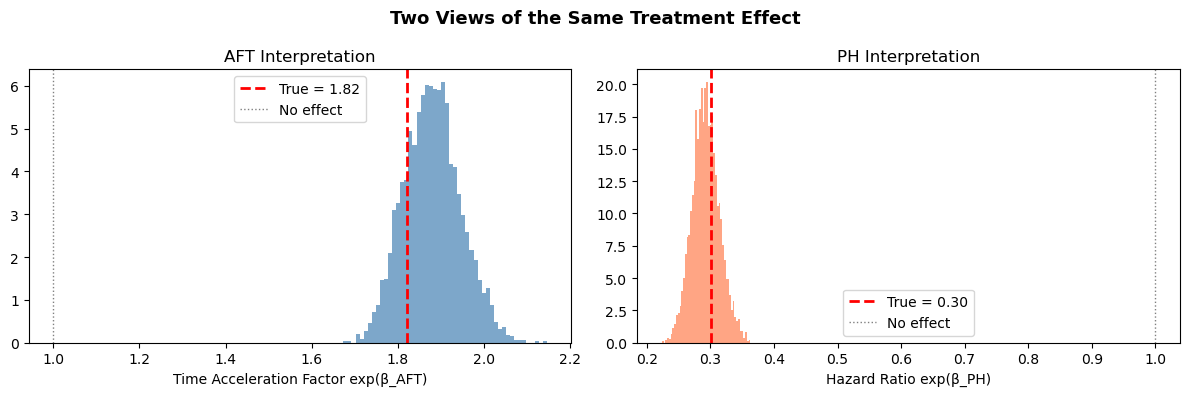

In [15]:
#| fig-cap: "The same treatment effect expressed in AFT (time ratio) and PH (hazard ratio) scales. These are two lenses on the same underlying quantity."

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# AFT scale: time acceleration factor
time_ratio = np.exp(beta_aft_treatment).values.flatten()
axes[0].hist(time_ratio, bins=50, density=True, alpha=0.7, color='steelblue')
axes[0].axvline(np.exp(beta_treatment), color='red', linestyle='--', linewidth=2, label=f'True = {np.exp(beta_treatment):.2f}')
axes[0].axvline(1.0, color='gray', linestyle=':', linewidth=1, label='No effect')
axes[0].set_xlabel('Time Acceleration Factor exp(β_AFT)')
axes[0].set_title('AFT Interpretation')
axes[0].legend()

# PH scale: hazard ratio
hr = hazard_ratio.values.flatten()
axes[1].hist(hr, bins=50, density=True, alpha=0.7, color='coral')
axes[1].axvline(np.exp(-shape_true * beta_treatment), color='red', linestyle='--', linewidth=2,
                label=f'True = {np.exp(-shape_true * beta_treatment):.2f}')
axes[1].axvline(1.0, color='gray', linestyle=':', linewidth=1, label='No effect')
axes[1].set_xlabel('Hazard Ratio exp(β_PH)')
axes[1].set_title('PH Interpretation')
axes[1].legend()

plt.suptitle('Two Views of the Same Treatment Effect', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Deriving Survival and Hazard Curves

A fitted parametric model is only useful if we can translate its coefficients back into the quantities that matter: *how does the probability of surviving change over time, and how does the instantaneous risk evolve?* In this section we derive full survival and hazard curves from the fitted Weibull AFT model using two complementary approaches.

### Approach 1: Parametric Closed-Form Curves

The great advantage of a parametric model is that the survival and hazard functions have closed-form expressions. For a Weibull AFT model with shape $\alpha$ and subject-specific scale $\sigma_i = \exp(\mu + X_i \beta)$, we have:

$$\lambda(t \mid X_i) = \frac{\alpha}{\sigma_i}\left(\frac{t}{\sigma_i}\right)^{\alpha - 1}, \qquad S(t \mid X_i) = \exp\left(-\left(\frac{t}{\sigma_i}\right)^{\alpha}\right)$$

Since we have full posterior samples for $\alpha$, $\mu$ (intercept), and $\beta$, we can compute these curves for *every posterior draw* and then summarize with pointwise means and credible intervals. This propagates all parameter uncertainty into the curve estimates — no delta method or asymptotic approximations needed.


In [16]:
def weibull_survival_curves(idata, t_grid, covariate_values, var_names=None):
    """
    Compute parametric Weibull survival and hazard curves from posterior samples.

    Parameters
    ----------
    idata : az.InferenceData
        Fitted model's inference data (must contain 'Intercept', 'alpha',
        and covariate posteriors)
    t_grid : array
        Time points at which to evaluate the curves
    covariate_values : dict
        Covariate name -> value pairs for the target profile
    var_names : list, optional
        Names of covariates in the posterior. If None, uses keys of covariate_values.

    Returns
    -------
    dict with keys 'survival', 'hazard', 'cum_hazard', each of shape (n_draws, n_times),
    plus 't' (the time grid)
    """
    post = idata.posterior
    if var_names is None:
        var_names = list(covariate_values.keys())

    # Build log-scale: mu + X @ beta
    log_scale = post['Intercept'].values.flatten().copy()
    for name in var_names:
        log_scale = log_scale + post[name].values.flatten() * covariate_values[name]

    scale = np.exp(log_scale)  # shape: (n_draws,)
    alpha_samples = post['alpha'].values.flatten()  # shape: (n_draws,)

    # Broadcast: (n_draws, 1) vs (1, n_times)
    scale_2d = scale[:, np.newaxis]
    alpha_2d = alpha_samples[:, np.newaxis]
    t_2d = t_grid[np.newaxis, :]

    # Weibull functions
    survival = np.exp(-((t_2d / scale_2d) ** alpha_2d))
    hazard = (alpha_2d / scale_2d) * (t_2d / scale_2d) ** (alpha_2d - 1)
    cum_hazard = (t_2d / scale_2d) ** alpha_2d

    return {'survival': survival, 'hazard': hazard, 'cum_hazard': cum_hazard, 't': t_grid}

Now let's use this to compare survival curves for treated vs. control subjects, with full posterior uncertainty:


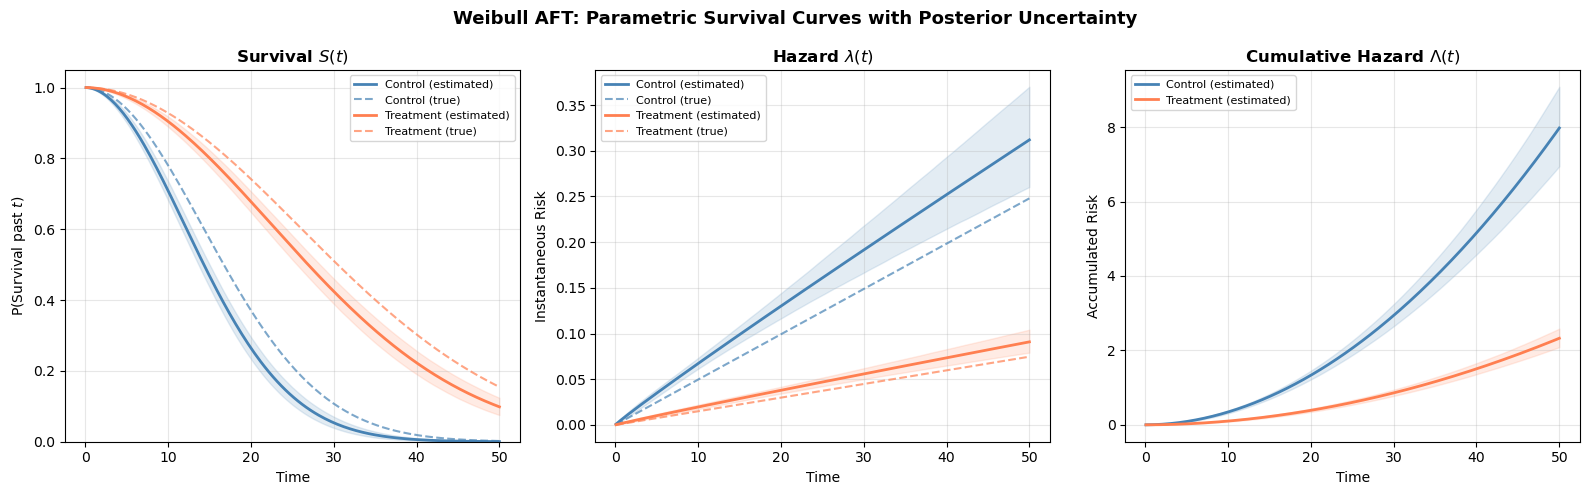

In [17]:
#| fig-cap: "Parametric survival and hazard curves derived from the Weibull AFT posterior. Shaded bands show 95% credible intervals; the treatment group's curves are shifted rightward (longer survival, lower hazard)."

t_grid = np.linspace(0.1, 50, 200)

curves_control = weibull_survival_curves(
    idata_aft, t_grid,
    covariate_values={'treatment': 0, 'age': 0}
)
curves_treated = weibull_survival_curves(
    idata_aft, t_grid,
    covariate_values={'treatment': 1, 'age': 0}
)

# Also compute true curves for comparison
scale_control_true = np.exp(intercept_true + beta_treatment * 0 + beta_age * 0)
scale_treated_true = np.exp(intercept_true + beta_treatment * 1 + beta_age * 0)

S_true_control = np.exp(-((t_grid / scale_control_true) ** shape_true))
S_true_treated = np.exp(-((t_grid / scale_treated_true) ** shape_true))
h_true_control = (shape_true / scale_control_true) * (t_grid / scale_control_true) ** (shape_true - 1)
h_true_treated = (shape_true / scale_treated_true) * (t_grid / scale_treated_true) ** (shape_true - 1)


fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for curves, label, color, S_true, h_true in [
    (curves_control, 'Control', 'steelblue', S_true_control, h_true_control),
    (curves_treated, 'Treatment', 'coral', S_true_treated, h_true_treated),
]:
    # Survival
    S_mean = curves['survival'].mean(axis=0)
    S_lo = np.percentile(curves['survival'], 2.5, axis=0)
    S_hi = np.percentile(curves['survival'], 97.5, axis=0)
    axes[0].plot(t_grid, S_mean, color=color, linewidth=2, label=f'{label} (estimated)')
    axes[0].fill_between(t_grid, S_lo, S_hi, color=color, alpha=0.15)
    axes[0].plot(t_grid, S_true, color=color, linestyle='--', linewidth=1.5, alpha=0.7, label=f'{label} (true)')

    # Hazard
    h_mean = curves['hazard'].mean(axis=0)
    h_lo = np.percentile(curves['hazard'], 2.5, axis=0)
    h_hi = np.percentile(curves['hazard'], 97.5, axis=0)
    axes[1].plot(t_grid, h_mean, color=color, linewidth=2, label=f'{label} (estimated)')
    axes[1].fill_between(t_grid, h_lo, h_hi, color=color, alpha=0.15)
    axes[1].plot(t_grid, h_true, color=color, linestyle='--', linewidth=1.5, alpha=0.7, label=f'{label} (true)')

    # Cumulative hazard
    ch_mean = curves['cum_hazard'].mean(axis=0)
    ch_lo = np.percentile(curves['cum_hazard'], 2.5, axis=0)
    ch_hi = np.percentile(curves['cum_hazard'], 97.5, axis=0)
    axes[2].plot(t_grid, ch_mean, color=color, linewidth=2, label=f'{label} (estimated)')
    axes[2].fill_between(t_grid, ch_lo, ch_hi, color=color, alpha=0.15)

axes[0].set_title('Survival $S(t)$', fontsize=12, fontweight='bold')
axes[0].set_ylabel('P(Survival past $t$)')
axes[0].set_ylim(0, 1.05)
axes[1].set_title('Hazard $\\lambda(t)$', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Instantaneous Risk')
axes[2].set_title('Cumulative Hazard $\\Lambda(t)$', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Accumulated Risk')

for ax in axes:
    ax.set_xlabel('Time')
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Weibull AFT: Parametric Survival Curves with Posterior Uncertainty',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

The estimated curves (solid lines with shaded credible bands) closely track the true data-generating curves (dashed lines). Notice how the treatment effect manifests as a *horizontal shift*: the treated group's survival curve is displaced rightward, and their hazard curve is displaced rightward and downward. This is the AFT effect in action — covariates stretch the time axis rather than scaling the hazard vertically.

## Approach 2: Posterior Predictive Survival Curves

The parametric approach above works beautifully when we have closed-form expressions for $S(t)$ and $\lambda(t)$. But what if we used a more complex model — perhaps one with splines, interactions, or a distribution without clean closed forms?

An alternative is the **posterior predictive** approach. We call `model.predict(kind="pps")` to have Bambi simulate survival times from the posterior predictive distribution for a hypothetical subject. Each posterior draw produces a simulated survival time, so across all draws we get a sample of plausible event times. From these we can construct an empirical survival curve: at each time point $t$, the survival estimate is simply the fraction of simulated times exceeding $t$.

This approach is general — it works for any model Bambi can fit, regardless of whether the survival function has a convenient closed-form expression.


In [18]:
def posterior_predictive_survival(model, idata, pred_data, t_grid):
    """
    Compute survival curves via posterior predictive simulation.

    Uses Bambi's predict(kind='pps') to draw survival times from the
    posterior predictive distribution, then computes the empirical
    survival function at each time in t_grid.

    Parameters
    ----------
    model : bmb.Model
        Fitted Bambi model
    idata : az.InferenceData
        Posterior samples
    pred_data : DataFrame
        DataFrame with covariate values for the target profile.
        Should have one row per desired prediction (typically one).
    t_grid : array
        Time points at which to evaluate survival

    Returns
    -------
    dict with 'survival' of shape (n_times,), 'survival_lo', 'survival_hi',
    'simulated_times', and 't'
    """
    # Draw survival times from the posterior predictive
    predictions = model.predict(idata, kind="pps", data=pred_data, inplace=False)
    pps = predictions.posterior_predictive

    # Get the response variable name and extract simulated times
    response_var = list(pps.data_vars)[0]
    # Shape: (chains, draws, obs) — flatten chains × draws for the single observation
    sim_times = pps[response_var].values[:, :, 0].flatten()

    # Empirical survival function: fraction of simulated times exceeding each t
    survival = np.array([np.mean(sim_times > t_val) for t_val in t_grid])

    # Bootstrap-style uncertainty: resample the simulated times
    rng = np.random.default_rng(42)
    n_boot = 500
    n_draws = len(sim_times)
    boot_survival = np.zeros((n_boot, len(t_grid)))
    for b in range(n_boot):
        boot_idx = rng.integers(0, n_draws, size=n_draws)
        boot_times = sim_times[boot_idx]
        for j, t_val in enumerate(t_grid):
            boot_survival[b, j] = np.mean(boot_times > t_val)

    return {
        'survival': survival,
        'survival_lo': np.percentile(boot_survival, 2.5, axis=0),
        'survival_hi': np.percentile(boot_survival, 97.5, axis=0),
        'simulated_times': sim_times,
        't': t_grid,
    }

The function above defines with posterior predictive workflow. The key point is that we can derive the survival curve from the fraction of posterior samples that exceed the value of t for each time point in the grid. 


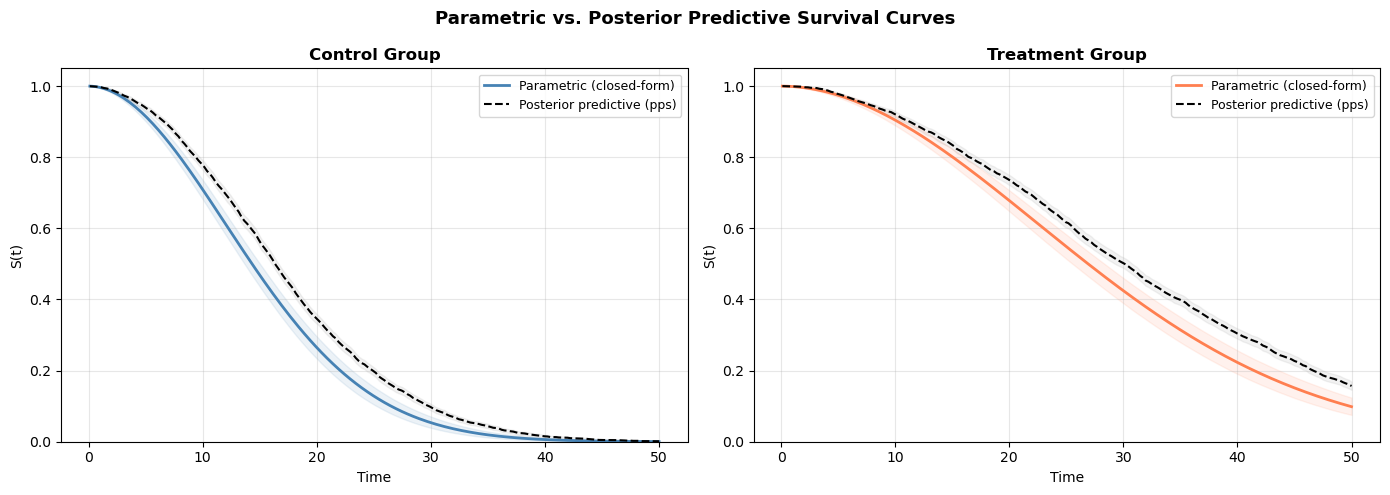

In [19]:
#| fig-cap: "Comparison of parametric (closed-form) and posterior predictive survival curves. The two approaches agree closely — the posterior predictive method is noisier due to simulation variance but requires no analytic formulas."

# Create single-row prediction DataFrames
pred_control = pd.DataFrame({'treatment': [0], 'age': [0.0],
                              'time': [np.nan], 'censoring': ['none']})
pred_treated = pd.DataFrame({'treatment': [1], 'age': [0.0],
                              'time': [np.nan], 'censoring': ['none']})

pps_control = posterior_predictive_survival(model_aft, idata_aft, pred_control, t_grid)
pps_treated = posterior_predictive_survival(model_aft, idata_aft, pred_treated, t_grid)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (label, color, param_curves, pps_curves) in enumerate([
    ('Control', 'steelblue', curves_control, pps_control),
    ('Treatment', 'coral', curves_treated, pps_treated),
]):
    ax = axes[idx]

    # Parametric (from Approach 1)
    S_param = param_curves['survival'].mean(axis=0)
    S_param_lo = np.percentile(param_curves['survival'], 2.5, axis=0)
    S_param_hi = np.percentile(param_curves['survival'], 97.5, axis=0)
    ax.plot(t_grid, S_param, color=color, linewidth=2, label='Parametric (closed-form)')
    ax.fill_between(t_grid, S_param_lo, S_param_hi, color=color, alpha=0.1)

    # Posterior predictive
    ax.plot(t_grid, pps_curves['survival'], color='black', linewidth=1.5,
            linestyle='--', label='Posterior predictive (pps)')
    ax.fill_between(t_grid, pps_curves['survival_lo'], pps_curves['survival_hi'],
                    color='gray', alpha=0.1)

    ax.set_title(f'{label} Group', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('S(t)')
    ax.set_ylim(0, 1.05)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Parametric vs. Posterior Predictive Survival Curves',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

The two approaches should agree closely. The parametric curves are smooth (computed from exact formulas); the posterior predictive curves are step-like (computed from a finite sample of simulated times). The agreement validates that our closed-form calculations are correct.

::: {.callout-tip}
## When to Use Which Approach

**Parametric (closed-form)**: Use when you have a standard distribution (Weibull, exponential, etc.) and want smooth, precise curves with minimal computational cost. The formulas are exact — no simulation noise.

**Posterior predictive (`kind="pps"`)**: Use when:

- The model is complex (interactions, splines, random effects) and closed-form expressions are unwieldy
- You want to validate the parametric curves against a simulation-based check
- You're working with a distribution that lacks clean analytic survival/hazard functions
- You want to incorporate predictive uncertainty for new subjects, not just parameter uncertainty

In practice, for a simple Weibull AFT model the parametric approach is clearly preferred — it's faster and smoother. The posterior predictive approach becomes essential for more complex models where the survival function can't be written down in closed form.
:::

## Applied Example: Employee Retention

Now let's apply these methods to a real-world problem. We'll model employee retention using a dataset tracking how long employees stayed before leaving (or being right-censored at the end of the observation window). People Analytics often has a focus on process and change dynamics. Whether we assess career trajectories in terms of time-to-promotion or time-to-attrition, we must track the development of an individual within a role, within a company and team. Understanding how these processes evolve and what factors of the time or place accelerate the outcomes is essential to organisational design and people management.

### Data Exploration

In our dataset we record a number of "demographic" like variables, but additionally we have surveyed each individual to record their sentiment and whether they intend to leave. These are standard measures in typical employee-engagement surveys. 

In [20]:
retention_df = pd.read_csv("data/retention.csv")

print(f"Dataset: {len(retention_df)} employees")
print(f"\nOutcome:")
print(f"  Left (event):      {retention_df['left'].sum()} ({100*retention_df['left'].mean():.1f}%)")
print(f"  Stayed (censored): {(1 - retention_df['left']).sum()} ({100*(1-retention_df['left'].mean()):.1f}%)")
print(f"\nTime range: {retention_df['month'].min()} to {retention_df['month'].max()} months")
print(f"\nCovariates:")
print(f"  Gender: {retention_df['gender'].value_counts().to_dict()}")
print(f"  Level:  {retention_df['level'].value_counts().to_dict()}")
print(f"  Field:  {retention_df['field'].nunique()} unique fields")
print(f"  Sentiment: {retention_df['sentiment'].min()}-{retention_df['sentiment'].max()} (continuous)")
print(f"  Intention: {retention_df['intention'].min()}-{retention_df['intention'].max()} (continuous)")

Dataset: 3770 employees

Outcome:
  Left (event):      1354 (35.9%)
  Stayed (censored): 2416 (64.1%)

Time range: 1 to 12 months

Covariates:
  Gender: {'M': 2603, 'F': 1167}
  Level:  {'Low': 2519, 'Medium': 787, 'High': 464}
  Field:  6 unique fields
  Sentiment: 1-10 (continuous)
  Intention: 1-10 (continuous)


The thought is that these features will appropriately stratify the population and give us insight into the risk of attrition for different types of employee. These insights should help us anticipate future needs across the various employee profiles. It is natural to think that different careers accumulate risk more or less quickly. Stresses in one position might considerably outweigh the risks in another. Some work might be seasonal or age dependent. It is insight into the factors which accelerate attrition events that we want to understand. 

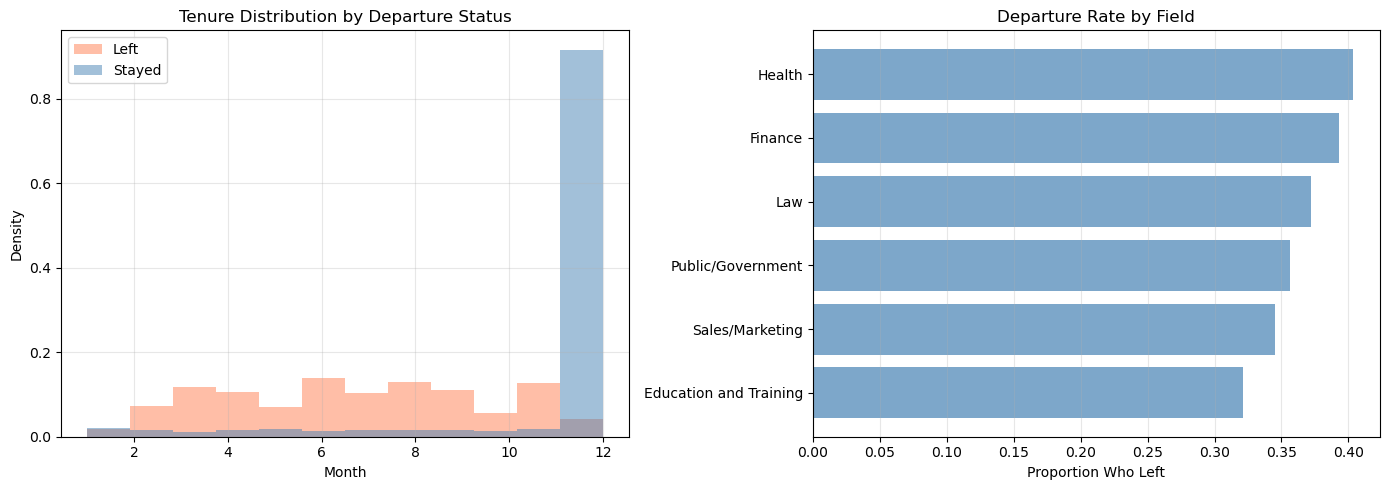

In [21]:
#| fig-cap: "Distribution of tenure and departure status across employee fields"

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Tenure distribution by event status
for event_val, label, color in [(1, 'Left', 'coral'), (0, 'Stayed', 'steelblue')]:
    subset = retention_df[retention_df['left'] == event_val]
    axes[0].hist(subset['month'], bins=12, alpha=0.5, density=True,
                 label=label, color=color)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Density')
axes[0].set_title('Tenure Distribution by Departure Status')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Event rate by field
field_rates = retention_df.groupby('field')['left'].mean().sort_values()
axes[1].barh(field_rates.index, field_rates.values, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Proportion Who Left')
axes[1].set_title('Departure Rate by Field')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### Preparing the Data

Again we need to specify the censored observations to make the data ready for modelling. 

In [22]:
# Create censoring indicator
retention_df['censoring'] = np.where(retention_df['left'] == 1, 'none', 'right')

### Model 1: Retention Weibull AFT

We start with a Weibull AFT model including gender, seniority level, field, employee sentiment, and intention to leave as predictors.


In [23]:
def fit_retention_model(retention_df, formula, likelihood='weibull', noncentred=True):
    """Fit a parametric survival model to the retention data."""
    if likelihood == 'weibull':
        family = "weibull"
    elif likelihood == 'exponential':
        family = "exponential"
    else:
        raise ValueError("Unsupported likelihood. Choose 'weibull' or 'exponential'")

    model = bmb.Model(
        formula,
        data=retention_df,
        family=family,
        link="log",
        noncentered=noncentred
    )

    print(f"\n{'='*60}")
    print(f"Fitting {likelihood.upper()} AFT model")
    print(f"{'='*60}")
    print(model)

    idata = model.fit(
        draws=1000,
        tune=1000,
        chains=4,
        random_seed=42,
        target_accept=0.95,
        inference_method='nutpie',
        idata_kwargs={"log_likelihood": True}
    )
    return idata, model

In [24]:
#| output: false
formula_base = "censored(month, censoring) ~ C(gender) + C(level) + C(field) + sentiment + intention"

idata_weibull, model_weibull = fit_retention_model(retention_df, formula_base, likelihood='weibull')


Fitting WEIBULL AFT model
       Formula: censored(month, censoring) ~ C(gender) + C(level) + C(field) + sentiment + intention
        Family: weibull
          Link: mu = log
  Observations: 3770
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 13.3078)
            C(gender) ~ Normal(mu: 0.0, sigma: 5.4077)
            C(level) ~ Normal(mu: [0. 0.], sigma: [5.3093 6.1513])
            C(field) ~ Normal(mu: [0. 0. 0. 0. 0.], sigma: [ 5.2512 11.8505 13.      7.2383  8.4543])
            sentiment ~ Normal(mu: 0.0, sigma: 1.3939)
            intention ~ Normal(mu: 0.0, sigma: 1.1996)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.35,15
,2000,0,0.41,15
,2000,0,0.36,7
,2000,0,0.44,7


In [25]:
print("WEIBULL AFT — POSTERIOR SUMMARY")
print("=" * 60)
az.summary(idata_weibull, hdi_prob=0.95)

WEIBULL AFT — POSTERIOR SUMMARY


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_log__,0.518,0.026,0.468,0.566,0.000,0.000,2760.0,2518.0,1.0
Intercept,3.372,0.118,3.146,3.603,0.002,0.002,3207.0,2622.0,1.0
C(gender)[M],-0.010,0.035,-0.075,0.060,0.000,0.001,5130.0,3038.0,1.0
C(level)[Low],-0.103,0.053,-0.201,0.006,0.001,0.001,2693.0,2972.0,1.0
C(level)[Medium],-0.072,0.061,-0.191,0.051,0.001,0.001,2657.0,2882.0,1.0
C(field)[Finance],-0.153,0.041,-0.230,-0.071,0.001,0.001,3236.0,2814.0,1.0
C(field)[Health],-0.149,0.078,-0.300,0.003,0.001,0.001,3940.0,3058.0,1.0
C(field)[Law],-0.045,0.087,-0.223,0.113,0.001,0.001,4832.0,3026.0,1.0
C(field)[Public/Government],-0.081,0.054,-0.184,0.026,0.001,0.001,3679.0,2945.0,1.0
C(field)[Sales/Marketing],-0.065,0.061,-0.191,0.052,0.001,0.001,3926.0,3163.0,1.0


::: {.callout-note}
## Reading the Retention Coefficients

Since this is an AFT model:

- **Positive coefficients** mean *longer retention* (the employee stays longer)
- **Negative coefficients** mean *shorter retention* (the employee leaves sooner)
- `sentiment` and `intention` are on their original scales, so a one-unit increase in sentiment has the indicated effect on log-time

For example, if the sentiment coefficient is positive, higher job satisfaction is associated with longer tenure — the employee's "survival time" in the role is stretched.
:::

### Model 2: Exponential AFT


In [26]:
#| output: false
idata_exp_ret, model_exp_ret = fit_retention_model(retention_df, formula_base, likelihood='exponential')


Fitting EXPONENTIAL AFT model
       Formula: censored(month, censoring) ~ C(gender) + C(level) + C(field) + sentiment + intention
        Family: exponential
          Link: mu = log
  Observations: 3770
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 13.3078)
            C(gender) ~ Normal(mu: 0.0, sigma: 5.4077)
            C(level) ~ Normal(mu: [0. 0.], sigma: [5.3093 6.1513])
            C(field) ~ Normal(mu: [0. 0. 0. 0. 0.], sigma: [ 5.2512 11.8505 13.      7.2383  8.4543])
            sentiment ~ Normal(mu: 0.0, sigma: 1.3939)
            intention ~ Normal(mu: 0.0, sigma: 1.1996)


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.38,7
,2000,0,0.40,7
,2000,0,0.43,7
,2000,0,0.37,7


In [27]:
print("EXPONENTIAL AFT — POSTERIOR SUMMARY")
print("=" * 60)
az.summary(idata_exp_ret, hdi_prob=0.95)

EXPONENTIAL AFT — POSTERIOR SUMMARY


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.171,0.192,3.771,4.524,0.004,0.003,2857.0,2438.0,1.0
C(gender)[M],-0.016,0.058,-0.125,0.099,0.001,0.001,5107.0,3030.0,1.0
C(level)[Low],-0.160,0.092,-0.355,0.009,0.002,0.002,2478.0,2615.0,1.0
C(level)[Medium],-0.111,0.106,-0.318,0.094,0.002,0.002,2447.0,2532.0,1.0
C(field)[Finance],-0.239,0.068,-0.363,-0.098,0.001,0.001,2938.0,3015.0,1.0
C(field)[Health],-0.239,0.128,-0.489,0.014,0.002,0.002,4024.0,2767.0,1.0
C(field)[Law],-0.074,0.144,-0.346,0.211,0.002,0.002,4459.0,3126.0,1.0
C(field)[Public/Government],-0.122,0.088,-0.287,0.045,0.002,0.001,3223.0,3067.0,1.0
C(field)[Sales/Marketing],-0.103,0.102,-0.294,0.108,0.002,0.002,4089.0,2854.0,1.0
sentiment,0.029,0.015,-0.002,0.057,0.000,0.000,3985.0,3420.0,1.0


Showing similar coefficient estimates. 

### Model 3: Weibull AFT with Frailty (Random Effects)

Employees in different fields may share unobserved characteristics that affect retention — organizational culture, industry norms, career mobility patterns. A **frailty model** captures this by adding a random effect (random intercept) for field. This is the survival-analysis equivalent of a random-intercept multilevel model.

The frailty term absorbs unobserved heterogeneity between fields that isn't captured by the fixed effect of field alone. It also provides partial pooling: fields with fewer observations borrow strength from the overall distribution, leading to more stable estimates.


In [28]:
#| output: false
formula_frailty = "censored(month, censoring) ~ C(gender) + C(level) + sentiment + intention + (1|field)"

idata_frailty, model_frailty = fit_retention_model(retention_df, formula_frailty, likelihood='weibull', noncentred=False)


Fitting WEIBULL AFT model
       Formula: censored(month, censoring) ~ C(gender) + C(level) + sentiment + intention + (1|field)
        Family: weibull
          Link: mu = log
  Observations: 3770
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 13.0974)
            C(gender) ~ Normal(mu: 0.0, sigma: 5.4077)
            C(level) ~ Normal(mu: [0. 0.], sigma: [5.3093 6.1513])
            sentiment ~ Normal(mu: 0.0, sigma: 1.3939)
            intention ~ Normal(mu: 0.0, sigma: 1.1996)
        
        Group-level effects
            1|field ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 13.0974))
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.29,15
,2000,0,0.29,15
,2000,0,0.32,15
,2000,0,0.34,15


In [29]:
print("WEIBULL AFT + FRAILTY — POSTERIOR SUMMARY")
print("=" * 60)
az.summary(idata_frailty, hdi_prob=0.95)

WEIBULL AFT + FRAILTY — POSTERIOR SUMMARY


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_log__,0.520,0.025,0.470,0.567,0.000,0.000,3766.0,3190.0,1.00
Intercept,3.281,0.119,3.053,3.518,0.003,0.002,2118.0,2384.0,1.00
C(gender)[M],-0.011,0.036,-0.081,0.058,0.000,0.001,5311.0,2724.0,1.00
C(level)[Low],-0.100,0.054,-0.206,0.006,0.001,0.001,2879.0,2938.0,1.00
C(level)[Medium],-0.069,0.061,-0.189,0.049,0.001,0.001,2772.0,2613.0,1.00
sentiment,0.019,0.009,-0.000,0.035,0.000,0.000,5490.0,3366.0,1.00
intention,-0.123,0.009,-0.139,-0.106,0.000,0.000,4574.0,2897.0,1.00
1|field_sigma_log__,-2.666,0.539,-3.744,-1.569,0.018,0.014,961.0,1101.0,1.01
1|field[Education and Training],0.067,0.051,-0.029,0.172,0.002,0.003,762.0,711.0,1.00
1|field[Finance],-0.057,0.049,-0.153,0.037,0.002,0.002,825.0,660.0,1.01


Here we see the estimated posterior parameterisation of the random effects model. The rank order and direction of the coefficients by field are generally a useful way to assess risk of attrition. Additionally, the `1|field_sigma` parameter is useful to check the degree of variability in field specific effects. 

### Model Comparison


In [30]:
with model_weibull.backend.model:
    idata_weibull = pm.compute_log_likelihood(idata_weibull)

with model_exp_ret.backend.model:
    idata_exp_ret = pm.compute_log_likelihood(idata_exp_ret)

with model_frailty.backend.model:
    idata_frailty = pm.compute_log_likelihood(idata_frailty)

compare_retention = az.compare(
    {'Weibull': idata_weibull, 'Exponential': idata_exp_ret,
    'Weibull + Frailty': idata_frailty},
    ic='loo'
)

print("MODEL COMPARISON (LOO-CV)")
print("=" * 60)
print(compare_retention)

Output()

Output()

Output()

MODEL COMPARISON (LOO-CV)
                   rank     elpd_loo      p_loo   elpd_diff        weight  \
Weibull + Frailty     0 -5825.307563  47.540675    0.000000  1.000000e+00   
Weibull               1 -5938.112522  54.331563  112.804959  2.153849e-11   
Exponential           2 -6058.576057  48.844394  233.268495  1.706672e-10   

                           se        dse  warning scale  
Weibull + Frailty  111.985126   0.000000    False   log  
Weibull            116.522392   4.733293    False   log  
Exponential        118.640865  15.059649    False   log  


With the comparison of models we see that the random effects weibull model is to be preferred over the two alternatives. 

### Retention Survival Curves by Field

Let's put the survival curve machinery to work on the retention data. We use the posterior predictive approach here — it lets Bambi handle all the categorical dummy encoding internally, so we don't have to guess variable names. We just pass in a DataFrame with the desired covariate profile and let the model simulate survival times.

The EDA above showed that departure rates vary meaningfully across fields. Let's see whether the fitted Weibull model captures these differences as distinct survival curves.


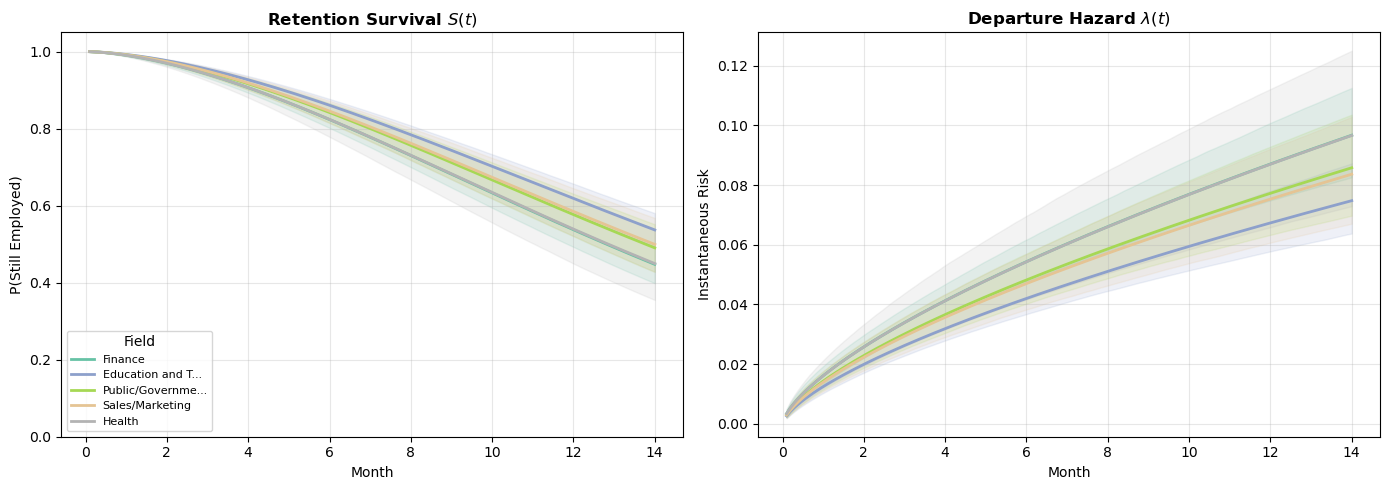

In [ ]:
# 1. SETUP (Time grid and categories)
t_ret = np.linspace(0.1, 14, 150)
fields_to_plot = retention_df['field'].value_counts().head(5).index.tolist()
med_sent = retention_df['sentiment'].median()
med_intent = retention_df['intention'].median()

# 2. BATCH PREDICTION
pred_df = pd.DataFrame({
    'month': [1.0] * 5,
    'censoring': ['none'] * 5,
    'gender': ['F'] * 5,
    'level': ['Low'] * 5,
    'field': fields_to_plot,
    'sentiment': [med_sent] * 5,
    'intention': [med_intent] * 5,
})

# kind="mean" returns the scale parameter sigma (the months)
results = model_weibull.predict(idata_weibull, kind="mean", data=pred_df, inplace=False)
mu_matrix = results.posterior["mu"].stack(sample=("chain", "draw")).values # Shape: (5, samples)
alpha_samples = idata_weibull.posterior["alpha"].stack(sample=("chain", "draw")).values # Shape: (samples,)

# 3. PLOTTING
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = plt.cm.Set2(np.linspace(0, 1, len(fields_to_plot)))

for i, field_name in enumerate(fields_to_plot):
    # USE DIRECTLY: mu_matrix already contains exp(linear_predictor)
    sigma_samples = mu_matrix[i, :]

    # Broadcast for calculation
    sig_2d = sigma_samples[:, np.newaxis]
    alp_2d = alpha_samples[:, np.newaxis]
    t_2d = t_ret[np.newaxis, :]

    # S(t) = exp(-(t/sigma)^alpha) 
    S_dist = np.exp(-((t_2d / sig_2d) ** alp_2d))

    # h(t) = (alpha/sigma) * (t/sigma)^(alpha-1) 
    h_dist = (alp_2d / sig_2d) * (t_2d / sig_2d) ** (alp_2d - 1)

    # Summary Statistics
    S_mean = S_dist.mean(axis=0)
    S_hdi = np.percentile(S_dist, [2.5, 97.5], axis=0)
    h_mean = h_dist.mean(axis=0)
    h_hdi = np.percentile(h_dist, [2.5, 97.5], axis=0)

    # Plotting
    label = field_name[:15] + "..." if len(field_name) > 15 else field_name
    axes[0].plot(t_ret, S_mean, color=colors[i], lw=2, label=label)
    axes[0].fill_between(t_ret, S_hdi[0], S_hdi[1], color=colors[i], alpha=0.15)

    axes[1].plot(t_ret, h_mean, color=colors[i], lw=2)
    axes[1].fill_between(t_ret, h_hdi[0], h_hdi[1], color=colors[i], alpha=0.15)

# Formatting
axes[0].set_title('Retention Survival $S(t)$', fontweight='bold')
axes[0].set_ylabel('P(Still Employed)')
axes[0].set_ylim(0, 1.05)
axes[0].legend(title='Field', loc='lower left', fontsize=8)

axes[1].set_title('Departure Hazard $\lambda(t)$', fontweight='bold')
axes[1].set_ylabel('Instantaneous Risk')

for ax in axes:
    ax.set_xlabel('Month')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

These curves translate the AFT coefficients into directly interpretable predictions. For an employee with median sentiment and intention scores, what is their probability of still being employed at month $t$? Fields with higher departure rates in the raw data produce lower survival curves here — the model has learned these differences from the data.

We can also use the closed-form parametric approach for comparison. This requires us to inspect the posterior variable names that Bambi created and manually assemble the linear predictor:


### Visualizing Coefficients Across Models


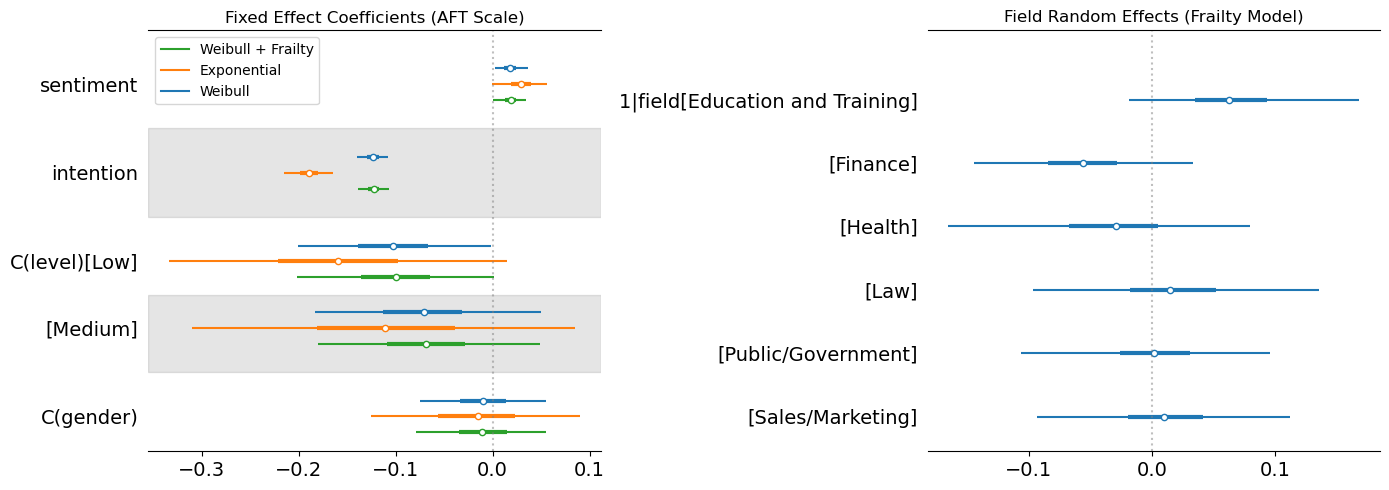

In [32]:
#| fig-cap: "Comparison of coefficient estimates across the three parametric models. The frailty model replaces the fixed field effects with a random intercept."

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fixed effects shared across all models
az.plot_forest(
    [idata_weibull, idata_exp_ret, idata_frailty],
    var_names=['sentiment', 'intention', 'C(level)', 'C(gender)'],
    model_names=['Weibull', 'Exponential', 'Weibull + Frailty'],
    combined=True, ax=axes[0]
)
axes[0].set_title("Fixed Effect Coefficients (AFT Scale)")
axes[0].axvline(0, color='gray', linestyle=':', alpha=0.5)

# Frailty random effects (only in frailty model)
az.plot_forest(
    idata_frailty,
    var_names=['1|field'],
    combined=True, ax=axes[1]
)
axes[1].set_title("Field Random Effects (Frailty Model)")
axes[1].axvline(0, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

::: {.callout-tip}
## When to Use Frailty Models

Frailty models are most useful when:

- You have **grouped data** with potential cluster-level heterogeneity (e.g., patients within hospitals, employees within departments)
- The number of groups is **moderate to large** (5+ groups) but group sizes may vary
- You want **partial pooling**: groups with fewer observations are shrunk toward the grand mean, borrowing strength from the overall distribution
- You want to account for **unobserved confounders** that vary across groups

They are less useful when you have very few groups (a fixed effect may be more appropriate) or when between-group variation is negligible.
:::

## Beyond the Weibull: Alternative Parametric Families

So far we've relied on the Weibull (and its special case, the exponential) for all our continuous-time models. The Weibull is a powerful default — but it enforces a **monotonic hazard**. Real-world processes often have non-monotonic risk profiles: surgical recovery risk peaks in the first days then declines, employee attrition may spike early and then stabilize, and disease relapse can follow a hump-shaped pattern.

In this section we fit **log-normal** and **log-logistic** models to the same simulated data and compare how the choice of distributional family shapes the estimated hazard and survival curves. This highlights a fundamental feature of continuous-time parametric models: your distributional assumption is a substantive claim about the shape of risk over time, not just a technical convenience.

To fit these alternative families in Bambi, we use its **custom family** mechanism. Bambi ships with built-in support for common families (Gaussian, Bernoulli, Poisson, Weibull, etc.), but survival analysis often calls for distributions that aren't included out of the box. Bambi's custom family lets you define any likelihood you need by specifying:

1. **A `Likelihood` object** — declares the distribution name, its parameters, and which parameter the linear predictor targets (the "parent").
2. **A `Family` object** — wraps the likelihood and specifies the link function for the parent parameter.
3. **Priors** for any auxiliary parameters (shape, scale, etc.) that aren't modeled by the regression formula.

For distributions that PyMC already knows (like the log-normal), you only need steps 1–3. For distributions PyMC *doesn't* have (like the log-logistic), you also provide a custom `dist` class with `logp` and `logcdf` methods — essentially teaching PyMC how to evaluate the likelihood. The `logcdf` is needed because censored observations contribute their survival probability $S(t) = 1 - F(t)$ to the likelihood rather than the density $f(t)$.

Below we demonstrate both cases.

### Log-Normal

The **log-normal** distribution arises when $\log(T)$ is normally distributed. Its key properties for survival analysis:

- **Non-monotonic hazard**: The hazard rises initially, reaches a peak, then declines toward zero. This makes it suitable for processes where risk increases early on but diminishes for long-term survivors — for example, recovery times from surgery, or time to relapse for certain cancers.
- **AFT only**: The log-normal does not satisfy the proportional hazards assumption, so coefficients have only the AFT (time ratio) interpretation.
- **Heavier right tail** than the Weibull, which can be appropriate when some subjects survive much longer than the bulk.

Since PyMC already includes the log-normal distribution, we only need to declare the likelihood and family:


In [33]:
# 1. Define the Likelihood (mu = location, sigma = scale)
lognormal_likelihood = bmb.Likelihood(
    name="LogNormal",
    params=["mu", "sigma"],
    parent="mu"
)

# 2. Define the Family
lognormal_family = bmb.Family(
    name="lognormal",
    likelihood=lognormal_likelihood,
    link="identity"
)

# 3. Define the Prior for sigma (must be positive, e.g., HalfNormal or Exponential)
# We use a dictionary where the key matches the param name in the likelihood
my_priors = {"sigma": bmb.Prior("HalfNormal", sigma=1)}

# 4. Fit the model
model_lognorm = bmb.Model(
    "censored(time, censoring) ~ treatment + age",
    data=df,
    family=lognormal_family,
    priors=my_priors
)

print(model_lognorm)

#| output: false
idata_lognormal = model_lognorm.fit(
    draws=1000,
    tune=1000,
    chains=4,
    random_seed=42,
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True}
)

az.summary(idata_lognormal)

Initializing NUTS using jitter+adapt_diag...


       Formula: censored(time, censoring) ~ treatment + age
        Family: lognormal
          Link: mu = identity
  Observations: 1000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.5338)
            treatment ~ Normal(mu: 0.0, sigma: 5.0001)
            age ~ Normal(mu: 0.0, sigma: 2.5292)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 1.0)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, treatment, age]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.724,0.017,0.692,0.755,0.000,0.000,4792.0,2866.0,1.0
Intercept,2.684,0.032,2.629,2.748,0.000,0.001,4422.0,2981.0,1.0
treatment,0.644,0.046,0.556,0.726,0.001,0.001,4910.0,3019.0,1.0
age,-0.405,0.024,-0.449,-0.358,0.000,0.000,5376.0,2885.0,1.0


### Log-Logistic

The **log-logistic** distribution arises when $\log(T)$ follows a logistic distribution. It shares several features with the log-normal but has some distinct advantages:

- **Non-monotonic hazard**: Like the log-normal, the hazard can rise then fall — but the log-logistic has a closed-form survival function $S(t) = 1/(1 + (t/\lambda)^{1/\alpha})$, which makes computation simpler.
- **AFT only**: No proportional hazards representation.
- **Proportional odds**: The log-logistic is the only common survival distribution that satisfies the **proportional odds** assumption, which can be useful when odds ratios are the natural estimand.
- **Common in economics and social science**: Often used for modelling duration data (unemployment spells, time to adoption of a technology) where the hazard is hump-shaped.

PyMC does not include the log-logistic distribution, so we need to define a custom distribution class with `logp` and `logcdf` methods. The `logcdf` is essential: for censored observations, the likelihood contribution is $S(t_i) = 1 - F(t_i)$, which PyMC computes from the CDF.


In [34]:
# 1. The Wrapper Class with **kwargs to handle PyMC internal arguments
class LogLogisticWrapper:
    @staticmethod
    def logp(value, mu, alpha, **kwargs): # Added **kwargs
        z = (pt.log(value) - mu) / alpha
        return z - pt.log(alpha) - pt.log(value) - 2 * pt.log1p(pt.exp(z))

    @staticmethod
    def logcdf(value, mu, alpha, **kwargs): # Added **kwargs
        z = (pt.log(value) - mu) / alpha
        return -pt.log1p(pt.exp(-z))

    @classmethod
    def dist(cls, mu, alpha, **kwargs):
        return pm.CustomDist.dist(
            mu, alpha,
            logp=cls.logp,
            logcdf=cls.logcdf,
            **kwargs
        )

# 2. Define the Likelihood and Family
loglogistic_likelihood = bmb.Likelihood(
    name="LogLogistic",
    params=["mu", "alpha"],
    parent="mu",
    dist=LogLogisticWrapper
)

log_logistic_family = bmb.Family(
    name="loglogistic",
    likelihood=loglogistic_likelihood,
    link="identity"
)

# 3. Define Priors
# Using a slightly informative HalfNormal for alpha (the scale/shape parameter)
priors = {"alpha": bmb.Prior("HalfNormal", sigma=1)}

# 4. Build and Fit
model_loglogistic = bmb.Model(
    "censored(time, censoring) ~ treatment + age",
    data=df,
    family=log_logistic_family,
    priors=priors
)

idata_loglogistic = model_loglogistic.fit(draws=1000, tune=1000, target_accept=0.9,  idata_kwargs={"log_likelihood": True})

# 5. Summarize
az.summary(idata_loglogistic, var_names=["Intercept", "treatment", "age", "alpha"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, treatment, age]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.756,0.028,2.704,2.807,0.000,0.000,4788.0,3084.0,1.0
treatment,0.608,0.041,0.536,0.691,0.001,0.001,4654.0,3062.0,1.0
age,-0.398,0.022,-0.435,-0.354,0.000,0.000,4329.0,2995.0,1.0
alpha,0.377,0.011,0.356,0.397,0.000,0.000,4503.0,3058.0,1.0


### Comparing Parametric Families

Having fit Weibull, log-normal, and log-logistic models to the same data, we can now visualize how these distributional assumptions shape the estimated hazard and survival curves. Each family imposes a different structural constraint on the hazard:

- **Weibull**: Monotonic hazard — either always increasing, always decreasing, or constant. Determined by a single shape parameter.
- **Log-normal**: Hump-shaped hazard — rises to a peak then declines toward zero. Appropriate when long-term survivors face diminishing risk.
- **Log-logistic**: Also hump-shaped, but with heavier tails than the log-normal. The hazard declines more slowly, reflecting sustained (though decreasing) risk.

The plot below shows all three fitted models for the baseline profile (control group, average age), with 94% credible intervals. Differences between the curves reflect the structural assumptions of each family, not just statistical uncertainty.


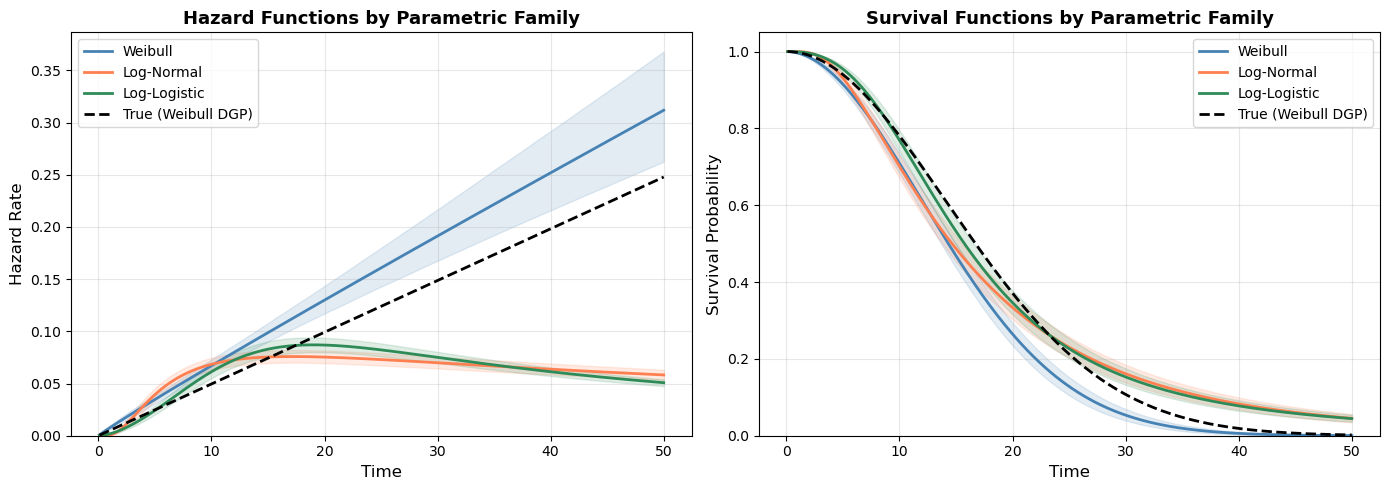

In [35]:
#| fig-cap: "Hazard and survival curves from three parametric families fitted to the same data. Differences reflect distributional assumptions about hazard shape."

def lognormal_survival_curves(idata, t_grid, covariate_values):
    """Compute survival and hazard curves from a log-normal AFT posterior."""
    from scipy.stats import norm

    post = idata.posterior
    mu_samples = post['Intercept'].values.flatten().copy()
    for name, val in covariate_values.items():
        mu_samples = mu_samples + post[name].values.flatten() * val
    sigma_samples = post['sigma'].values.flatten()

    mu_2d = mu_samples[:, np.newaxis]
    sigma_2d = sigma_samples[:, np.newaxis]
    t_2d = t_grid[np.newaxis, :]

    # Log-normal: S(t) = 1 - Phi((log(t) - mu) / sigma)
    z = (np.log(t_2d) - mu_2d) / sigma_2d
    survival = 1 - norm.cdf(z)
    # Hazard: f(t) / S(t), where f(t) = phi(z) / (t * sigma)
    pdf = norm.pdf(z) / (t_2d * sigma_2d)
    hazard = pdf / np.maximum(survival, 1e-12)

    return {'survival': survival, 'hazard': hazard, 't': t_grid}


def loglogistic_survival_curves(idata, t_grid, covariate_values):
    """Compute survival and hazard curves from a log-logistic AFT posterior."""
    from scipy.special import expit

    post = idata.posterior
    mu_samples = post['Intercept'].values.flatten().copy()
    for name, val in covariate_values.items():
        mu_samples = mu_samples + post[name].values.flatten() * val
    alpha_samples = post['alpha'].values.flatten()

    mu_2d = mu_samples[:, np.newaxis]
    alpha_2d = alpha_samples[:, np.newaxis]
    t_2d = t_grid[np.newaxis, :]

    # Log-logistic: S(t) = 1 / (1 + exp(z)), where z = (log(t) - mu) / alpha
    z = (np.log(t_2d) - mu_2d) / alpha_2d
    survival = 1 / (1 + np.exp(z))
    # Hazard: f(t) / S(t) = exp(z) / (alpha * t * (1 + exp(z)))
    hazard = np.exp(z) / (alpha_2d * t_2d * (1 + np.exp(z)))

    return {'survival': survival, 'hazard': hazard, 't': t_grid}


# Compute curves for baseline profile (control, average age)
t_compare = np.linspace(0.1, 50, 300)
cov_baseline = {'treatment': 0, 'age': 0}

curves_weibull = weibull_survival_curves(idata_aft, t_compare, cov_baseline)
curves_lognorm = lognormal_survival_curves(idata_lognormal, t_compare, cov_baseline)
curves_loglog = loglogistic_survival_curves(idata_loglogistic, t_compare, cov_baseline)

# True curves from the known DGP (Weibull, baseline profile)
scale_true_baseline = np.exp(intercept_true)
h_true = (shape_true / scale_true_baseline) * (t_compare / scale_true_baseline) ** (shape_true - 1)
s_true = np.exp(-((t_compare / scale_true_baseline) ** shape_true))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

families = [
    (curves_weibull, 'Weibull', 'steelblue'),
    (curves_lognorm, 'Log-Normal', 'coral'),
    (curves_loglog, 'Log-Logistic', 'seagreen'),
]

for curves, label, color in families:
    # Hazard
    h_mean = np.mean(curves['hazard'], axis=0)
    h_lo, h_hi = np.quantile(curves['hazard'], [0.03, 0.97], axis=0)
    axes[0].plot(t_compare, h_mean, color=color, linewidth=2, label=label)
    axes[0].fill_between(t_compare, h_lo, h_hi, color=color, alpha=0.15)

    # Survival
    s_mean = np.mean(curves['survival'], axis=0)
    s_lo, s_hi = np.quantile(curves['survival'], [0.03, 0.97], axis=0)
    axes[1].plot(t_compare, s_mean, color=color, linewidth=2, label=label)
    axes[1].fill_between(t_compare, s_lo, s_hi, color=color, alpha=0.15)

# Overlay true curves
axes[0].plot(t_compare, h_true, 'k--', linewidth=2, label='True (Weibull DGP)')
axes[1].plot(t_compare, s_true, 'k--', linewidth=2, label='True (Weibull DGP)')

axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylabel('Hazard Rate', fontsize=12)
axes[0].set_title('Hazard Functions by Parametric Family', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(bottom=0)

axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylabel('Survival Probability', fontsize=12)
axes[1].set_title('Survival Functions by Parametric Family', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

The black dashed line shows the true data-generating process (a Weibull). The hazard panel is the most revealing: the Weibull fit tracks the true monotonically increasing hazard closely, while the log-normal and log-logistic impose a hump-shaped hazard that peaks and then declines — a structural mismatch with the DGP. This is why LOO favors the Weibull: not because it has more parameters, but because its structural assumption happens to match reality.

The survival panel shows that all three models broadly agree on the overall survival trajectory — they're fitting the same data, after all — but they diverge in the tails, where the structural assumptions matter most and data is sparsest. The log-normal and log-logistic overestimate survival at late times because their declining hazards imply a slower accumulation of risk than the true DGP.

We can also formally compare model fit using LOO:


In [36]:
comparison = az.compare(
    {'Weibull': idata_aft, 'LogNormal': idata_lognormal, 'LogLogistic': idata_loglogistic},
    ic='loo'
)
print(comparison)

             rank     elpd_loo     p_loo   elpd_diff        weight         se  \
Weibull         0 -3429.162411  4.017912    0.000000  1.000000e+00  32.738848   
LogLogistic     1 -3487.611871  4.283159   58.449460  3.469447e-12  35.849259   
LogNormal       2 -3544.763709  6.631496  115.601298  7.540857e-12  44.234439   

                   dse  warning scale  
Weibull       0.000000    False   log  
LogLogistic   8.253952    False   log  
LogNormal    23.580648    False   log  


## Competing Risks: When Multiple Processes Accumulate Simultaneously

The survival models we've built so far assume a single risk process — one cause, one accumulating hazard, one event. But many real phenomena involve multiple, simultaneous risk processes each pushing toward their own distinct endpoint.

Consider a clinical trial tracking cardiovascular mortality. At any moment, a patient is not only accumulating cardiovascular risk but also non-cardiovascular risk — infection, cancer, organ failure. These processes run in parallel, and crucially, they *compete*: a patient who dies from non-cardiovascular causes is no longer at risk of cardiovascular death. Treating non-cardiovascular deaths as simple censoring — the naive single-cause approach — implicitly assumes they tell us nothing about cardiovascular risk. But that is only valid if the two processes are unrelated, which in practice they rarely are.

This is the competing risks problem: an individual faces $K$ distinct risk processes accumulating simultaneously, and we observe whichever event fires first. The statistical challenge is that each cause's hazard contributes to the probability of *surviving long enough to experience any event at all*. The overall survival function is not determined by any single cause in isolation — it is determined by the sum of all competing cumulative hazards:

$$S(t) = \exp\!\left(-\sum_{k=1}^{K} \Lambda_k(t)\right)$$

This has a direct consequence for the likelihood. When we observe individual $i$ still alive at time $t_i$, that survival reflects the joint action of all $K$ hazards, not just the one they eventually succumb to (or would have, had observation continued). Every individual informs every cause's hazard through this shared survival term — even those who were censored, and even those who died from a different cause.

The **Cumulative Incidence Function (CIF)** for cause $k$ captures this properly:

$$F_k(t) = \int_0^t h_k(s) \cdot S(s) \, ds$$

This is *not* simply $1 - S_k(t)$ from a cause-specific survival model. It is the probability of failing from cause $k$ before time $t$, accounting for the fact that competing causes may remove individuals from the risk set first. Summing CIFs across all causes and adding the overall survival gives back 1 at every time point — a coherent probability partition:

$$\sum_{k=1}^{K} F_k(t) + S(t) = 1$$

The Weibull competing risks model below encodes this structure directly in the likelihood. Two linear predictors — one per cause — feed into a single joint log-likelihood where both causes' hazards appear in every observation's survival contribution.

Lets set up the data generating process:

In [37]:
# =========================================================
# FULL WEIBULL COMPETING RISKS EXAMPLE (Bambi + PyMC)
# =========================================================


# ---------------------------------------------------------------------
# 1. DATA GENERATING PROCESS (Weibull competing risks)
# ---------------------------------------------------------------------
rng = np.random.default_rng(123)
n = 2_000

age       = rng.normal(65, 10, n)
sex       = rng.binomial(1, 0.5, n).astype(float)
treatment = rng.binomial(1, 0.5, n)
age_c     = age - 65

TRUE = {
    # Cause 1
    "intercept_1": -3.5,
    "age_c_1":      0.03,
    "sex_1":        0.50,
    "trt_1":       -1.00,
    "alpha1":       1.5,   # Weibull shape

    # Cause 2
    "intercept_2": -4.2,
    "age_c_2":      0.02,
    "sex_2":       -0.30,
    "trt_2":        0.00,
    "alpha2":       1.2,   # Weibull shape
}

eta1 = (
    TRUE["intercept_1"]
    + TRUE["age_c_1"] * age_c
    + TRUE["sex_1"]   * sex
    + TRUE["trt_1"]   * treatment
)

eta2 = (
    TRUE["intercept_2"]
    + TRUE["age_c_2"] * age_c
    + TRUE["sex_2"]   * sex
    + TRUE["trt_2"]   * treatment
)

lambda1 = np.exp(eta1)
lambda2 = np.exp(eta2)

alpha1 = TRUE["alpha1"]
alpha2 = TRUE["alpha2"]

# ---- Simulate latent Weibull times ----
u1 = rng.uniform(size=n)
u2 = rng.uniform(size=n)

T1 = (-np.log(u1) / lambda1) ** (1.0 / alpha1)
T2 = (-np.log(u2) / lambda2) ** (1.0 / alpha2)

t_event = np.minimum(T1, T2)
cause   = np.where(T1 < T2, 1, 2)

# ---- Random right censoring ----
C      = rng.uniform(0, 15, size=n)
time   = np.minimum(t_event, C)
status = np.where(t_event <= C, cause, 0)

df = pd.DataFrame({
    "time":      time,
    "status":    status,
    "age_c":     age_c,
    "sex":       sex,
    "treatment": np.where(treatment == 1, "B", "A"),
})

print("Event counts:") # Cause 0 = censored, 1 = Cardiovascular death, 2 = non-Cardiovascular death
print(df["status"].value_counts().rename({0: "censored", 1: "cv_death", 2: "noncv_death"}))
print(f"Censoring rate: {(status == 0).mean():.1%}")

Event counts:
status
censored       1114
cv_death        680
noncv_death     206
Name: count, dtype: int64
Censoring rate: 55.7%


Now we need to set up our custom likelihood 

In [38]:
# ---------------------------------------------------------------------
# 2. Shared cause indicators
# ---------------------------------------------------------------------
delta1_shared = pytensor.shared(
    (df["status"] == 1).astype(float).values, name="delta1"
)
delta2_shared = pytensor.shared(
    (df["status"] == 2).astype(float).values, name="delta2"
)

# ---------------------------------------------------------------------
# 3. Weibull competing risks log-likelihood
# ---------------------------------------------------------------------
def cr_weibull_logp(value, mu, eta2, alpha1, alpha2):

    lambda1 = pt.exp(mu)
    lambda2 = pt.exp(eta2)

    log_t = pt.log(value)

    # cause-specific log hazards
    log_h1 = mu + pt.log(alpha1) + (alpha1 - 1.0) * log_t
    log_h2 = eta2 + pt.log(alpha2) + (alpha2 - 1.0) * log_t

    log_haz = delta1_shared * log_h1 + delta2_shared * log_h2

    # survival contribution
    log_surv = -lambda1 * value**alpha1 - lambda2 * value**alpha2

    return log_haz + log_surv


def cr_weibull_dist(name, mu, eta2, alpha1, alpha2, **kwargs):
    return pm.CustomDist(
        name,
        mu,
        eta2,
        alpha1,
        alpha2,
        logp=cr_weibull_logp,
        **kwargs,
    )


cr_likelihood = bmb.Likelihood(
    name="CompetingRisksWeibull",
    params=["mu", "eta2", "alpha1", "alpha2"],
    parent="mu",
    dist=cr_weibull_dist,
)

cr_family = bmb.Family(
    name="competing_risks_weibull",
    likelihood=cr_likelihood,
    link={"mu": "identity", "eta2": "identity"},
)

# ---------------------------------------------------------------------
# 4. Model specification
# ---------------------------------------------------------------------
formula = bmb.Formula(
    "time ~ age_c + sex + treatment",
    "eta2 ~ age_c + sex + treatment",
)

priors = {
    # Cause 1 coefficients
    "Intercept":        bmb.Prior("Normal", mu=-3.5, sigma=2),
    "age_c":            bmb.Prior("Normal", mu=0, sigma=0.5),
    "sex":              bmb.Prior("Normal", mu=0, sigma=1),
    "treatment":        bmb.Prior("Normal", mu=0, sigma=1),

    # Cause 2 coefficients
    "eta2_Intercept":   bmb.Prior("Normal", mu=-4.2, sigma=2),
    "eta2_age_c":       bmb.Prior("Normal", mu=0, sigma=0.5),
    "eta2_sex":         bmb.Prior("Normal", mu=0, sigma=1),
    "eta2_treatment":   bmb.Prior("Normal", mu=0, sigma=1),

    # Weibull shapes (positive)
    "alpha1":           bmb.Prior("LogNormal", mu=0, sigma=0.5),
    "alpha2":           bmb.Prior("LogNormal", mu=0, sigma=0.5),
}

model = bmb.Model(
    formula,
    data=df,
    family=cr_family,
    priors=priors,
)

model.build()

# ---------------------------------------------------------------------
# 5. Sampling
# ---------------------------------------------------------------------
idata = model.fit(
    draws=2000,
    tune=1000,
    chains=4,
    target_accept=0.9,
    random_seed=42,
    idata_kwargs={"log_likelihood": True},
)

az.summary(idata, hdi_prob=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha2, alpha1, Intercept, age_c, sex, treatment, eta2_Intercept, eta2_age_c, eta2_sex, eta2_treatment]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha2,1.101,0.064,0.976,1.228,0.001,0.001,8040.0,5940.0,1.0
alpha1,1.559,0.048,1.466,1.654,0.001,0.001,9147.0,6306.0,1.0
Intercept,-3.645,0.116,-3.862,-3.411,0.001,0.001,9951.0,6238.0,1.0
age_c,0.030,0.004,0.023,0.038,0.000,0.000,13077.0,5498.0,1.0
sex,0.364,0.078,0.205,0.511,0.001,0.001,14127.0,4996.0,1.0
treatment[B],-0.951,0.079,-1.098,-0.782,0.001,0.001,12650.0,5849.0,1.0
eta2_Intercept,-4.019,0.170,-4.362,-3.691,0.002,0.002,9561.0,6333.0,1.0
eta2_age_c,0.024,0.007,0.010,0.036,0.000,0.000,13433.0,5439.0,1.0
eta2_sex,-0.213,0.139,-0.487,0.053,0.001,0.002,11471.0,5559.0,1.0
eta2_treatment[B],-0.052,0.141,-0.323,0.227,0.001,0.002,12046.0,5454.0,1.0


### Cumulative Incidence Functions

Having fit the competing risks model, the natural inferential target is not the regression coefficients themselves but the **Cumulative Incidence Function (CIF)** — the probability that an individual has experienced a specific cause of failure by time $t$, given their covariate profile.

The CIF is the right quantity to report in a competing risks analysis for a subtle but important reason. The intuitive alternative — computing $1 - S_k(t)$ from a cause-specific survival model — overstates the risk of each individual cause. It implicitly asks: *what is the probability of CV death by time $t$ in a world where non-CV death does not exist?* That is not a useful clinical or policy question. Patients do not live in worlds where competing causes have been eliminated.

The CIF instead asks: *what is the probability of CV death by time $t$ in the real world, where the patient is simultaneously at risk of dying from other causes?* Formally:

$$F_k(t \mid \mathbf{x}) = \int_0^t h_k(s \mid \mathbf{x}) \cdot S(s \mid \mathbf{x}) \, ds$$

The joint survival term $S(s)$ inside the integral is doing the key work. It discounts the incidence of cause $k$ at each moment $s$ by the probability of having survived all causes up to that point. A patient who is likely to die early from a competing cause accumulates less incidence from the primary cause — not because their cause-specific hazard is lower, but because they are less likely to be alive and at risk.

This disentanglement matters practically. Suppose treatment B dramatically reduces CV mortality. In a naive single-cause analysis, this might appear to slightly *increase* non-CV mortality — not because treatment is harmful, but because patients now live long enough to experience non-CV events they would previously never have reached. The CIFs make this transparent: CV incidence falls, non-CV incidence rises mechanically as a consequence, and the overall survival improvement is visible in both panels simultaneously.

Three properties make CIFs the preferred reporting standard in competing risks analyses:

**Coherent probability accounting.** The CIFs and the overall survival partition the probability space exhaustively at every time point: $\sum_k F_k(t) + S(t) = 1$. You can read off, for any covariate profile and any time horizon, the probability of each outcome — including remaining event-free.

**Sensitivity to both hazards.** Because both $\lambda_1$ and $\lambda_2$ enter the survival term, the CIF for cause 1 responds to changes in the cause-2 hazard even when cause-2 coefficients are held fixed. This captures the real-world substitution between competing risks.

**Direct policy relevance.** In clinical trials, the CIF answers the question clinicians and patients actually care about: *given this treatment and this patient profile, what is the probability of this specific bad outcome within five years?* The cause-specific hazard ratio is a mechanistic quantity; the CIF is an absolute risk quantity grounded in real-world incidence.


Sanity check — F1 + F2 + S at t=15: 0.999846  (should be ≈ 1)
Max deviation from 1.0 across time grid: 1.55e-04


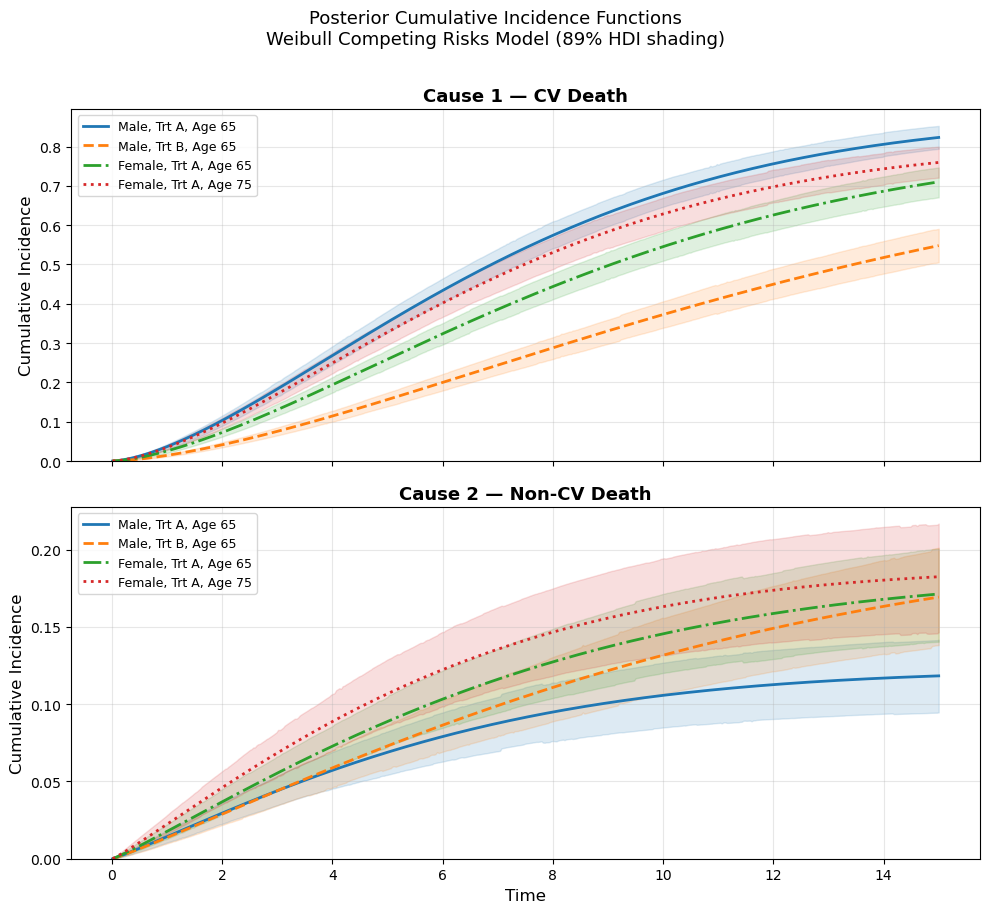

In [39]:

# ---------------------------------------------------------------------------
# Helper: compute CIFs from posterior draws
# ---------------------------------------------------------------------------

def compute_cif(t_grid, lambda1, lambda2, alpha1, alpha2):
    """
    Numerically integrate the CIF for both causes over t_grid.

    Parameters
    ----------
    t_grid   : (T,)    array of evaluation times
    lambda1  : (S,)    posterior draws of cause-1 scale  [exp(eta1)]
    lambda2  : (S,)    posterior draws of cause-2 scale  [exp(eta2)]
    alpha1   : (S,)    posterior draws of cause-1 shape
    alpha2   : (S,)    posterior draws of cause-2 shape

    Returns
    -------
    cif1, cif2 : each (S, T)  — one CIF curve per posterior draw
    survival   : (S, T)
    """
    S = len(lambda1)
    T = len(t_grid)

    # Broadcast: shapes (S, T)
    t  = t_grid[np.newaxis, :]          # (1, T)
    l1 = lambda1[:, np.newaxis]         # (S, 1)
    l2 = lambda2[:, np.newaxis]
    a1 = alpha1[:, np.newaxis]
    a2 = alpha2[:, np.newaxis]

    # Weibull hazards  (S, T)
    h1 = l1 * a1 * t ** (a1 - 1)
    h2 = l2 * a2 * t ** (a2 - 1)

    # Joint survival  (S, T)
    surv = np.exp(-l1 * t ** a1 - l2 * t ** a2)

    # Integrand for each cause  (S, T)
    integrand1 = h1 * surv
    integrand2 = h2 * surv

    # Trapezoidal integration along time axis  → (S, T)
    cif1 = np.zeros((S, T))
    cif2 = np.zeros((S, T))
    for j in range(1, T):
        dt = t_grid[j] - t_grid[j - 1]
        cif1[:, j] = cif1[:, j-1] + 0.5 * (integrand1[:, j-1] + integrand1[:, j]) * dt
        cif2[:, j] = cif2[:, j-1] + 0.5 * (integrand2[:, j-1] + integrand2[:, j]) * dt

    return cif1, cif2, surv


def extract_posterior_draws(idata, covariate_profile, df):
    """
    Compute lambda1, lambda2 from posterior draws for a given covariate profile.

    covariate_profile : dict, e.g. {"age_c": 0, "sex": 1, "treatment": "B"}
    """
    post = idata.posterior

    # Stack chains and draws → flat arrays
    def flat(var):
        return post[var].values.reshape(-1)

    # Intercepts and slopes — cause 1
    eta1 = flat("Intercept")
    eta1 = eta1 + flat("age_c")      * covariate_profile["age_c"]
    eta1 = eta1 + flat("sex")        * covariate_profile["sex"]

    # treatment is a categorical contrast; bambi stores it as "treatment[treatment[B]]"
    # find the right variable name
    trt_var_1 = [v for v in post.data_vars if "treatment" in v and "eta2" not in v][0]
    trt_var_2 = [v for v in post.data_vars if "treatment" in v and "eta2" in v][0]
    trt_indicator = 1.0 if covariate_profile["treatment"] == "B" else 0.0
    eta1 = eta1 + flat(trt_var_1) * trt_indicator

    # Cause 2
    eta2 = flat("eta2_Intercept")
    eta2 = eta2 + flat("eta2_age_c") * covariate_profile["age_c"]
    eta2 = eta2 + flat("eta2_sex")   * covariate_profile["sex"]
    eta2 = eta2 + flat(trt_var_2)    * trt_indicator

    lambda1 = np.exp(eta1)
    lambda2 = np.exp(eta2)
    alpha1  = flat("alpha1")
    alpha2  = flat("alpha2")

    return lambda1, lambda2, alpha1, alpha2


def cif_summary(cif, hdi_prob=0.89):
    """Return mean and HDI bounds across posterior draws."""
    mean = cif.mean(axis=0)
    hdi  = az.hdi(cif, hdi_prob=hdi_prob)
    return mean, hdi[:, 0], hdi[:, 1]


# ---------------------------------------------------------------------------
# Define covariate profiles to plot
# ---------------------------------------------------------------------------
profiles = {
    "Male, Trt A, Age 65":   {"age_c": 0,  "sex": 1, "treatment": "A"},
    "Male, Trt B, Age 65":   {"age_c": 0,  "sex": 1, "treatment": "B"},
    "Female, Trt A, Age 65": {"age_c": 0,  "sex": 0, "treatment": "A"},
    "Female, Trt A, Age 75": {"age_c": 10, "sex": 0, "treatment": "A"},
}

t_grid = np.linspace(0.01, 15, 500)

# ---------------------------------------------------------------------------
# Plot: 2 rows (cause 1, cause 2) × 1 column, all profiles overlaid
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(10, 9), sharex=True)

colours = ["C0", "C1", "C2", "C3"]
linestyles = ["-", "--", "-.", ":"]

for (label, profile), colour, ls in zip(profiles.items(), colours, linestyles):
    lambda1, lambda2, alpha1, alpha2 = extract_posterior_draws(
        idata, profile, df
    )
    cif1, cif2, surv = compute_cif(t_grid, lambda1, lambda2, alpha1, alpha2)

    mean1, lo1, hi1 = cif_summary(cif1)
    mean2, lo2, hi2 = cif_summary(cif2)

    axes[0].plot(t_grid, mean1, color=colour, ls=ls, lw=2, label=label)
    axes[0].fill_between(t_grid, lo1, hi1, color=colour, alpha=0.15)

    axes[1].plot(t_grid, mean2, color=colour, ls=ls, lw=2, label=label)
    axes[1].fill_between(t_grid, lo2, hi2, color=colour, alpha=0.15)

axes[0].set_ylabel("Cumulative Incidence", fontsize=12)
axes[0].set_title("Cause 1 — CV Death", fontsize=13, fontweight="bold")
axes[0].legend(fontsize=9, loc="upper left")
axes[0].set_ylim(0, None)
axes[0].grid(alpha=0.3)

axes[1].set_ylabel("Cumulative Incidence", fontsize=12)
axes[1].set_xlabel("Time", fontsize=12)
axes[1].set_title("Cause 2 — Non-CV Death", fontsize=13, fontweight="bold")
axes[1].legend(fontsize=9, loc="upper left")
axes[1].set_ylim(0, None)
axes[1].grid(alpha=0.3)

plt.suptitle(
    "Posterior Cumulative Incidence Functions\n"
    "Weibull Competing Risks Model (89% HDI shading)",
    fontsize=13, y=1.01
)
plt.tight_layout()

# ---------------------------------------------------------------------------
# Sanity check: F1(t) + F2(t) + S(t) ≈ 1 for one profile
# ---------------------------------------------------------------------------
profile = list(profiles.values())[0]
lambda1, lambda2, alpha1, alpha2 = extract_posterior_draws(idata, profile, df)
cif1, cif2, surv = compute_cif(t_grid, lambda1, lambda2, alpha1, alpha2)

partition = cif1.mean(0) + cif2.mean(0) + surv.mean(0)
print(f"\nSanity check — F1 + F2 + S at t=15: {partition[-1]:.6f}  (should be ≈ 1)")
print(f"Max deviation from 1.0 across time grid: {np.abs(partition - 1).max():.2e}")

## Conclusion: The Shape of Accumulation

We began this series of notebooks with the Sorites paradox: one grain of sand is not a heap, but if you keep adding grains, eventually it becomes one. Survival analysis models this process — the gradual accumulation of risk that culminates in a qualitative change, a state-transition event.

In the discrete-time notebook, we approximated this accumulation period by period: each interval contributed a small increment of risk, and the person-period data structure made that accumulation explicit. The cloglog link ensured that our linear predictor operated on the log-survival scale — the natural currency of accumulated risk. That approach was flexible and assumption-light, but it discretized what is often a continuous process.

In this notebook, we moved to continuous time, where the accumulation of risk is described directly by the hazard function and its integral, the cumulative hazard. The parametric families we explored embody different theories about *how* risk accumulates:

- The **Weibull** says risk accumulates at a rate that is monotonically changing — either accelerating (like aging or material fatigue), decelerating (like infant mortality or burn-in failure), or staying constant (the memoryless exponential).
- The **log-normal** says risk builds to a peak and then recedes — a process where the danger is greatest in a critical window, after which survivors face diminishing threat.
- The **log-logistic** tells a similar story, but with a heavier tail — the danger recedes more slowly, reflecting a process where risk lingers even as it diminishes.
- The **Weibull competing-risk** model outlines how multiple parametric hazards can be operating at once. Reducing one risk gives the others more time to accumulate. These interactions are key for many applications. 

State-transition events i.e. qualitative changes in status occur everywhere: in clinical outcomes, in employee attrition, in mechanical failure, in the adoption of ideas. The challenge of survival analysis is to understand under what kind of process these changes emerge, and to let the data inform that understanding. The Bayesian approach gives us the tools to do this honestly: posterior uncertainty over parameters, model comparison via LOO, and the flexibility to encode our substantive beliefs about accumulation through the choice of model structure. 

#### Discrete vs. Continuous: Choosing Your Approach

| Feature | Discrete-Time (Cloglog) | Continuous-Time (Parametric AFT) |
|---------|------------------------|-------------------------------|
| **Baseline hazard** | Fully flexible (categorical dummies or splines) | Parametric (2 parameters) |
| **Data format** | Person-period expansion | One row per subject |
| **Coefficient interpretation** | Log hazard ratios (PH) | Log time ratios (AFT) |
| **Time scale** | Naturally discrete periods | Continuous (days, hours, etc.) |
| **Extrapolation** | No (beyond observed periods) | Yes (with caution) |
| **Assumption risk** | Minimal (baseline is flexible) | Misspecification if wrong family |
| **Computational cost** | Higher (expanded dataset) | Lower (compact data) |
| **Extensions** | Easy non-proportional hazards via interactions | Frailty models, custom families, Competing Risks |

In practice, the two approaches often give similar substantive answers. The choice depends on whether time is naturally discrete or continuous, whether you want parametric efficiency or nonparametric flexibility, and whether you prefer AFT or PH interpretation. Both are regression. Both model the accumulation of risk. They differ in how they represent time and what trade-offs they accept.

### Dissolving the Paradox?

Each of these methods is a different answer to the Sorites question: *how does the heap come into being?* All at once? Gradually and relentlessly? Through a critical period that passes? The choice of parametric family is not a technical nuisance, but a substantive claim about the developmental process that leads to the event. It matters when an event occurs, not merely that it does occur. The Sorites paradox endures because it asks for a sharp boundary where none exists. The proper question asks instead about the probable rate of state-transition over time. Time is a resource, and understanding how long each state is likely to last shapes how we act within it. The paradox results from a focus on the state-change rather than the process that yields the change.




# Session Info


In [40]:
import sys
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Bambi version: {bmb.__version__}")
print(f"ArviZ version: {az.__version__}")

Python version: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:28:54) [Clang 19.1.7 ]
NumPy version: 2.3.5
Pandas version: 2.3.3
Bambi version: 0.16.0
ArviZ version: 0.23.0


## Author

This notebook was contributed by Nathaniel Forde: https://nathanielf.github.io/